In [1]:
# coding:utf-8
import pandas as pd
import numpy as np
import scipy.integrate as spi
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['KaiTi'] # 指定默认字体
plt.rcParams['axes.unicode_minus'] = False
from ncov.reader import get_data,watch_data
import statsmodels.tsa.api as smt    
from statsmodels.tsa.stattools import adfuller
import torch
from torch.nn.parameter import Parameter
import torch.optim as optim
import os
import pickle
torch.set_default_tensor_type(torch.DoubleTensor)
import warnings
warnings.filterwarnings('ignore')

In [2]:
class SEIR_cell(torch.nn.Module):
    def __init__(self, N, beta_init=0.2586, gamma_2_init=0.018, theta_init=0.001, alpha_init=0.2):
        super(SEIR_cell, self).__init__()
        # self.date_len = date_len
        self.beta = Parameter(torch.tensor([beta_init], requires_grad=True))
        self.N = Parameter(torch.tensor([N], requires_grad=False))
        self.gamma_2 = Parameter(torch.tensor([gamma_2_init], requires_grad=True))
        # self.gamma_2 = Parameter(torch.tensor([0.5], requires_grad=True))
        self.alpha = Parameter(torch.tensor([alpha_init], requires_grad=True))
        self.theta = Parameter(torch.tensor([theta_init], requires_grad=True))
        # self.theta = Parameter(torch.tensor([0.2], requires_grad=True))
        # self.E_ratio = Parameter(torch.tensor([3.], requires_grad=True))

    def clamp(self, X):
        # return torch.clamp(X, min=0, max=self.N)
        return X

    def act(self, X):
        return torch.pow(X,2)

    def forward(self, X):
        S, confirm, Exposed, recover, dead = X
        # self.beta = beta_old + self.beta_add
        # self.gamma_2 = gamma_2_old + self.gamma_2_add
        S_rest = S - self.act(self.beta)*confirm*S/self.N # dS/dt
        E = Exposed + self.act(self.beta)*confirm*S/self.N - self.act(self.alpha)*Exposed # dE/dt

        I = confirm + self.act(self.alpha)*Exposed - self.act(self.gamma_2)*confirm - self.act(self.theta)*confirm # dI/dt
        R = recover + self.act(self.gamma_2)*confirm # dR/dt
        D = dead + self.act(self.theta)*confirm

        # I = confirm + self.act(self.alpha)*E - self.act(self.gamma_2)*confirm - self.act(self.theta)*confirm # dI/dt
        # R = recover + self.act(self.gamma_2)*I # dR/dt
        # D = dead + self.act(self.theta)*I

        return S_rest, I, E, R, D, self.beta, self.gamma_2, self.theta, self.alpha
    
    def update_beta(self, b):
        self.beta = Parameter(torch.tensor([b], requires_grad=True))


In [3]:
class SEIR_model(torch.nn.Module):
    def __init__(self, date_len, pred_date_len=0, N=2870000., E_ratio_init=3., I_init=41, R_init=2., D_init=0., param={}):
        super(SEIR_model, self).__init__()
        self.SEIR_cells = torch.nn.ModuleList()
        self.SEIR_pred_cells = torch.nn.ModuleList()
        self.N = N
        self.E_ratio = E_ratio_init
        self.I = I_init
        self.E = (self.I * self.E_ratio)
        self.R = R_init
        self.D = D_init
        self.S = (self.N - self.I - self.E - self.R - self.D)
        self.date_len = date_len-1
        self.pred_date_len = pred_date_len
        if param!={}:
            len_param=len(param['beta'])
            self.beta_save = param['beta']
            self.gamma_2_save = param['gamma_2']
            self.alpha_save = param['alpha']
            self.theta_save = param['theta']
            for i in range(len_param):
                beta = self.beta_save[i]
                gamma_2 = self.gamma_2_save[i]
                alpha = self.alpha_save[i]
                theta = self.theta_save[i]
                self.SEIR_cells.append(SEIR_cell(self.N,beta,gamma_2,theta,alpha))
            if self.date_len>len_param:
                for i in range(len_param, self.date_len):
                    if len_param>=1:
                        beta = self.beta_save[len_param-1]
                        gamma_2 = self.gamma_2_save[len_param-1]
                        alpha = self.alpha_save[len_param-1]
                        theta = self.theta_save[len_param-1]
                        self.SEIR_cells.append(SEIR_cell(self.N,beta,gamma_2,theta,alpha)) 
                    else:
                        self.SEIR_cells.append(SEIR_cell(self.N)) 
        else:
            for i in range(self.date_len):
                self.SEIR_cells.append(SEIR_cell(self.N)) 

        self.S_tensor_cur = torch.zeros((self.date_len+1,))
        self.I_tensor_cur = torch.zeros((self.date_len+1,))
        self.E_tensor_cur = torch.zeros((self.date_len+1,))
        self.R_tensor_cur = torch.zeros((self.date_len+1,))
        self.D_tensor_cur = torch.zeros((self.date_len+1,))
        
    
    def forward(self, X):
        inp = self.S, self.I, self.E, self.R, self.D
        # param = beta_init, gamma_2_init
        S_tensor = torch.zeros((self.date_len+1,))
        I_tensor = torch.zeros((self.date_len+1,))
        E_tensor = torch.zeros((self.date_len+1,))
        R_tensor = torch.zeros((self.date_len+1,))
        D_tensor = torch.zeros((self.date_len+1,))
        S_tensor[0], I_tensor[0], E_tensor[0], R_tensor[0], D_tensor[0] = inp
        for i in range(self.date_len):
            if i == self.date_len-1: # we cannot update the last beta with grad
                self.beta = beta_cur
                self.SEIR_cells[i].update_beta(beta_cur)
            S, I, E, R, D, beta_cur, gamma_2_cur, theta_cur, alpha_cur = self.SEIR_cells[i](inp)
            S_tensor[i+1], I_tensor[i+1], E_tensor[i+1], R_tensor[i+1], D_tensor[i+1] = S, I, E, R, D
            self.beta = beta_cur
            self.gamma_2 = gamma_2_cur
            self.theta = theta_cur
            self.alpha = alpha_cur
            self.S_cur = S
            self.I_cur = I
            self.E_cur = E
            self.R_cur = R
            self.D_cur = D
            inp = [S, I, E, R, D]
        self.S_tensor_cur, self.I_tensor_cur, self.E_tensor_cur, self.R_tensor_cur, self.D_tensor_cur = S_tensor, I_tensor, E_tensor, R_tensor, D_tensor
        return S_tensor, I_tensor, E_tensor, R_tensor, D_tensor, beta_cur, gamma_2_cur

    def pred(self, pred_date_len, param={}):
        check_positive_replace = lambda x,y:y if x <=0 else x
        if param=={}:
            N_cur=self.N
            beta=self.beta
            gamma_2=self.gamma_2
            theta=self.theta
            alpha=self.alpha
        else:
            N_cur=self.N
            beta=check_positive_replace(param['beta'],self.beta)
            gamma_2=check_positive_replace(param['gamma_2'],self.gamma_2)
            theta=check_positive_replace(param['theta'],self.theta)
            alpha=check_positive_replace(param['alpha'],self.alpha)
        cur_pred_cells_len = len(self.SEIR_pred_cells)
        # print("cur_pred_cells_len:", cur_pred_cells_len)
        if cur_pred_cells_len!=pred_date_len:
            self.SEIR_pred_cells = torch.nn.ModuleList()
            for i in range(pred_date_len):
                self.SEIR_pred_cells.append(SEIR_cell(N_cur,beta,gamma_2,theta,alpha))
        S_pred_tensor = torch.zeros((pred_date_len,))
        I_pred_tensor = torch.zeros((pred_date_len,))
        E_pred_tensor = torch.zeros((pred_date_len,))
        R_pred_tensor = torch.zeros((pred_date_len,))
        D_pred_tensor = torch.zeros((pred_date_len,))
        # pred:
        inp = self.S_cur, self.I_cur, self.E_cur, self.R_cur, self.D_cur
        for i in range(pred_date_len):
            S, I, E, R, D, beta_, gamma_2_, theta_, alpha_ = self.SEIR_pred_cells[i](inp)
            S_pred_tensor[i], I_pred_tensor[i], E_pred_tensor[i], R_pred_tensor[i], D_pred_tensor[i] = S, I, E, R, D
            inp = [S, I, E, R, D]
        return S_pred_tensor, I_pred_tensor, E_pred_tensor, R_pred_tensor, D_pred_tensor


    def beta_pred(self, beta_list):
        check_positive = lambda x:0 if x <=0 else np.sqrt(x)
        sqrt_datas=[beta_list]
        datas = [list(np.square(d)) for d in sqrt_datas]
        params=['beta']
        param_dict={}
        for i in range(len(params)):
            param=params[i]
            data=datas[i]
            print("data:",data)
            data_copy=pd.DataFrame(data,columns=[param])
            dif_data=data_copy
            dif_data_list=[data_copy.values]
            dif=0
            p_value = adfuller(data_copy[param])[1]
            while p_value>0.05:
                dif=dif+1
                dif_data=dif_data.diff(1).dropna()
                dif_data_list.append(dif_data.values)
                p_value= adfuller(dif_data[param])[1]  
            pmax = int(len(data)/10) 
            qmax = int(len(data)/10)
            if dif>1:
                d=0
                data=dif_data
            else:
                d=dif
            bic_matrix = [] #bic矩阵
            for p in range(pmax+1):
                tmp = []
                for q in range(qmax+1):
                    try: #存在部分报错，所以用try来跳过报错。
                        tmp.append(smt.ARIMA(data, (p,d,q)).fit().bic)
                    except:
                        tmp.append(None)
                bic_matrix.append(tmp)
            bic_matrix = pd.DataFrame(bic_matrix) #从中可以找出最小值
            p,q = bic_matrix.stack().astype('float64').idxmin() #先用stack展平，然后用idxmin找出最小值位置。
            
            model = smt.ARIMA(data, (p,d,q)).fit() #建立ARIMA模型
            param_dict[param]=model.forecast(2)[0]
            print(param_dict[param])
            if dif>1:
                dif_data_list[-1]=np.append(dif_data_list[-1],param_dict[param])
                for i in range(dif,0,-1):
                    dif_data_list[i-1]=np.append(dif_data_list[i-1],dif_data_list[i][-2:]+dif_data_list[i-1][-2:])
                param_dict[param]=dif_data_list[0][-2:]
        # update beta by arima
        param_dict['beta'][0] = check_positive(param_dict['beta'][0])
        # param_dict['beta'][1] = check_positive(param_dict['beta'][1])
        self.SEIR_cells[-1].update_beta(param_dict['beta'][0])
        
        return param_dict['beta'][1]

    def param_pred(self,beta_list,gamma_2_list,theta_list,alpha_list):
        check_positive = lambda x:0 if x <=0 else np.sqrt(x)
        sqrt_datas=[gamma_2_list,theta_list,alpha_list]
        datas = [list(np.square(d)) for d in sqrt_datas]
        params=['gamma_2','theta','alpha']
        param_dict={}

        param_dict['beta'] = self.beta_pred(beta_list[:-1])

        for i in range(len(params)):
            param=params[i]
            data=datas[i]
            data_copy=pd.DataFrame(data,columns=[param])
            dif_data=data_copy
            dif_data_list=[data_copy.values]
            dif=0
            p_value = adfuller(data_copy[param])[1]
            while p_value>0.05:
                dif=dif+1
                dif_data=dif_data.diff(1).dropna()
                dif_data_list.append(dif_data.values)
                p_value= adfuller(dif_data[param])[1] 
            pmax = int(len(data)/10) 
            qmax = int(len(data)/10)
            if dif>1:
                d=0
                data=dif_data
            else:
                d=dif
            bic_matrix = [] #bic矩阵
            for p in range(pmax+1):
                tmp = []
                for q in range(qmax+1):
                    try: #存在部分报错，所以用try来跳过报错。
                        tmp.append(smt.ARIMA(data, (p,d,q)).fit().bic)
                    except:
                        tmp.append(None)
                bic_matrix.append(tmp)
            bic_matrix = pd.DataFrame(bic_matrix) #从中可以找出最小值
            p,q = bic_matrix.stack().astype('float64').idxmin() #先用stack展平，然后用idxmin找出最小值位置。
            
            model = smt.ARIMA(data, (p,d,q)).fit() #建立ARIMA(0, 1, 1)模型
            model.summary2() #给出一份模型报告
            param_dict[param]=model.forecast(1)[0][0]
            if dif>1:
                dif_data_list[-1]=np.append(dif_data_list[-1],param_dict[param])
                for i in range(1,dif+1,1):
                    dif_data_list[-i-1]=np.append(dif_data_list[-i-1],dif_data_list[-i][-1]+ dif_data_list[-i-1][-1])
                param_dict[param]=dif_data_list[0][-1]
        for k,v in param_dict.items():
            param_dict[k]=check_positive(v)
        return param_dict
    
        

In [162]:
def plot_SEIRD(data, I, R, D, xlen=10, city='武汉', pred_date_len=0):
    # len_data = len(list(set(data.index)))
    # print(len_data)
    plt.figure(figsize=(xlen, 6))
    T_name = 'time'
    time_val = data[T_name].values
    max_time_val = data[T_name].values.max()
    pred_time = []
    for i in range(1,pred_date_len+1):
        pred_time.append(max_time_val+np.timedelta64(i,'D')) 
    # print(pred_time)
    if pred_time==[]:
        merge_time = time_val
    else:
        merge_time = np.concatenate((time_val, pred_time),axis=0)
    plt.plot(merge_time, I, color = 'red', label = 'I-感染人数',marker = '.')
    plt.plot(merge_time, R, color = 'blue',label = 'R-治愈人数',marker = '.')
    # plt.plot(merge_time, S, color = 'darkgreen',label = 'S-易感人群',marker = '.')
    # plt.plot(merge_time, E, color = 'darkorange',label = 'E-疑似人数',marker = '.')
    plt.plot(merge_time, D, color = 'black',label = 'D-死亡人数',marker = '.')

    for a,b in zip(merge_time, I):
        plt.annotate('%s'%(b),xy=(a,b),xytext=(-5,5), textcoords='offset points',color='red')
    # for a,b in zip(merge_time, S):
    #     plt.annotate('%s'%(b),xy=(a,b),xytext=(-5,20), textcoords='offset points',color='darkgreen')

    city_title = '疫情状况-'+city
    plt.title(city_title)
    plt.legend()
    plt.xlabel('日期')   
    plt.ylabel('人数')
    plt.show()

def plot_param(model,city_name,data,xlen=10):
    T_name = 'time'
    time_val = data[T_name].values
    plt.figure(figsize=(xlen, 10))
    # pd.to_datetime()
    format_datetime = lambda x :f'0{x.date().month}-{x.date().day}' if x.date().month<10 else f'{x.date().month}-{x.date().day}'
    dates_list = [format_datetime(pd.to_datetime(d)) for d in time_val]
    beta = []
    gamma_2 = []
    theta = []
    alpha = []
    omega = []
    for i in range(len(model.SEIR_cells)):
        beta.append(model.SEIR_cells[i].beta.detach().numpy()[0])
        gamma_2.append(model.SEIR_cells[i].gamma_2.detach().numpy()[0])
        theta.append(model.SEIR_cells[i].theta.detach().numpy()[0])
        alpha.append(model.SEIR_cells[i].alpha.detach().numpy()[0])
        omega.append((model.SEIR_cells[i].theta.detach().numpy()[0])*0.)

    print('beta:',beta)
    print('gamma_2:',gamma_2)
    print('theta:',theta)
    print('alpha:',alpha)
    print('omega:',omega)
    plot_title = ['beta-感染率','gamma_2-治愈率','theta-死亡率','alpha-(疑似->感染)率','omega-疑似解除率']
    plot_list_sqrt = [beta,gamma_2,theta,alpha,omega]
    plot_list=[np.square(p) for p in plot_list_sqrt]
    colors=['blue','darkgreen','darkorange','red','purple']
    for i in range(len(colors)):
        plt.plot(dates_list[:len(beta)], plot_list[i],color=colors[i],label=plot_title[i],marker='x')
    for a, b in zip(range(len(beta)), beta):
        plt.annotate('%.4f' % (b), xy=(a, b), xytext=(-2, 2), textcoords='offset points', color=colors[0])
    plt.legend()
    title = 'Param changing process-'+city_name
    plt.title(title)
    plt.show()

def plot_daily_acc(data, accumulated_confirmed, accumulated_pred_confirmed,acc_cured,acc_pred_cured,xlen=10, city=u'武汉', pred_date_len=0):
    T_name = 'time'
    plt.figure(figsize=(xlen, 10))
    time_val = data[T_name].values

    max_time_val = data[T_name].values.max()
    pred_time = []
    for i in range(1, pred_date_len + 1):
        pred_time.append(max_time_val + np.timedelta64(i, 'D'))
    if pred_time == []:
        merge_time = time_val
    else:
        merge_time = np.concatenate((time_val, pred_time), axis=0)

    '''
    意思是在一个2行2列共4个子图的图中，定位第1个图来进行操作（画图）。
    最后面那个1表示第1个子图。那个数字的变化来定位不同的子图
    '''
    #第一行第一列图形
    ax1 = plt.subplot(2,1,1)
    #第一行第二列图形
    ax2 = plt.subplot(2,1,2)
    #第二行
    #选择ax1
    plt.sca(ax1)
    #绘制红色曲线
    plt.plot(time_val, accumulated_confirmed, color='red', label='累计确诊人数', marker='x')
    plt.plot(merge_time, accumulated_pred_confirmed, color='blue', label='预测的累计确诊人数', marker='x')
    for a, b in zip(merge_time, accumulated_pred_confirmed):
        plt.annotate('%s' % (b), xy=(a, b), xytext=(-5, 5), textcoords='offset points', color='blue')
    for a, b in zip(time_val, accumulated_confirmed):
        plt.annotate('%s' % (b), xy=(a, b), xytext=(-5, 20), textcoords='offset points', color='red')
    city_title = u'疫情状况-' + city
    plt.title(city_title)
    plt.legend()
    plt.xlabel(u'日期')
    plt.ylabel(u'人数')
    
    plt.sca(ax2)
    #绘制红色曲线
    plt.plot(time_val, acc_cured, color='red', label='累计治愈人数', marker='x')
    plt.plot(merge_time, acc_pred_cured, color='blue', label='预测的累计治愈人数', marker='x')
    for a, b in zip(merge_time, acc_pred_cured):
        plt.annotate('%s' % (b), xy=(a, b), xytext=(-5, 5), textcoords='offset points', color='blue')
    for a, b in zip(time_val, acc_cured):
        plt.annotate('%s' % (b), xy=(a, b), xytext=(-5, 20), textcoords='offset points', color='red')
    city_title = u'疫情状况-' + city
    plt.title(city_title)
    plt.legend()
    plt.xlabel(u'日期')
    plt.ylabel(u'人数')
    plt.savefig(city+u'累计预测')
    plt.show()
    return
    
def plot_daily_new(data, new_confirm, pred_new_confirm, new_cured,pred_new_cured,xlen=10, city=u'武汉', pred_date_len=0):
    plt.figure(figsize=(xlen, 10))
    T_name = 'time'
    time_val = data[T_name].values
    time_val = time_val[1:]
    max_time_val = data[T_name].values.max()
    pred_time = []
    for i in range(1,pred_date_len+1):
        pred_time.append(max_time_val+np.timedelta64(i,'D'))
    if pred_time==[]:
        merge_time = time_val
    else:
        merge_time = np.concatenate((time_val, pred_time),axis=0)
    ax1 = plt.subplot(2,1,1)
    #第一行第二列图形
    ax2 = plt.subplot(2,1,2)
    #第二行
    #选择ax1
    plt.sca(ax1)
    #绘制红色曲线
    plt.plot(time_val, new_confirm, color='red', label='新增确诊人数', marker='x')
    plt.plot(merge_time, pred_new_confirm, color='blue', label='预测的新增确诊人数', marker='x')
    for a, b in zip(merge_time, pred_new_confirm):
        plt.annotate('%s' % (b), xy=(a, b), xytext=(-5, 5), textcoords='offset points', color='blue')
    for a, b in zip(time_val, new_confirm):
        plt.annotate('%s' % (b), xy=(a, b), xytext=(-5, 20), textcoords='offset points', color='red')
    city_title = u'疫情状况-' + city
    plt.title(city_title)
    plt.legend()
    plt.xlabel(u'日期')
    plt.ylabel(u'人数')
    
    plt.sca(ax2)
    #绘制红色曲线
    plt.plot(time_val, new_cured, color='red', label='新增治愈人数', marker='x')
    plt.plot(merge_time, pred_new_cured, color='blue', label='预测的新增治愈人数', marker='x')
    for a, b in zip(merge_time, pred_new_cured):
        plt.annotate('%s' % (b), xy=(a, b), xytext=(-5, 5), textcoords='offset points', color='blue')
    for a, b in zip(time_val, new_cured):
        plt.annotate('%s' % (b), xy=(a, b), xytext=(-5, 20), textcoords='offset points', color='red')
    city_title = u'疫情状况-' + city
    plt.title(city_title)
    plt.legend()
    plt.xlabel(u'日期')
    plt.ylabel(u'人数')
    plt.savefig(city+u'新增预测')
    plt.show()
    return

def cal_acc_confirm(I,R,D):
    return I+R+D

def cal_new_confirm(I,R,D):
    acc_confirm = cal_acc_confirm(I,R,D)
    new_confirm = np.zeros((len(acc_confirm)-1))
    for i in range(len(acc_confirm)-1):
        new_confirm[i] = acc_confirm[i+1]-acc_confirm[i]
    return new_confirm

def get_data_acc_confirm(data,c='confirmed'):
    return np.array(data[c])

def save_param(model, model_city_date_path):
    save_path = os.path.join(model_city_date_path,'params/')
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    beta = []
    theta = []
    gamma_2 = []
    alpha = []
    for i in range(len(model.SEIR_cells)):
        beta.append(model.SEIR_cells[i].beta.detach().numpy()[0])
        gamma_2.append(model.SEIR_cells[i].gamma_2.detach().numpy()[0])
        theta.append(model.SEIR_cells[i].theta.detach().numpy()[0])
        alpha.append(model.SEIR_cells[i].alpha.detach().numpy()[0])
    param={'beta':beta,'theta':theta,'gamma_2':gamma_2,'alpha':alpha}
    with open(save_path + 'param.pkl', 'wb') as f:
        pickle.dump(param, f, pickle.HIGHEST_PROTOCOL)

def load_param(model_city_date_path):
    save_path = os.path.join(model_city_date_path,'params/')
    with open(save_path + 'param.pkl', 'rb') as f:
        return pickle.load(f)

def make_dir(city, date):
    save_root_path = 'models/'
    model_city_path = os.path.join(save_root_path, city)

    model_city_date_path = os.path.join(model_city_path, date)

    if not os.path.exists(model_city_date_path):
        print(model_city_date_path)
        os.makedirs(model_city_date_path)
    return model_city_date_path

def lr_decay(global_step,learning_rate=0.01,decay_rate=0.8,decay_steps=300):
    decayed_learning_rate = learning_rate * np.power(decay_rate,(global_step / decay_steps))
    return decayed_learning_rate

def train(data, model_city_date_path, lr_init=0.01, N=1e7, I_init=1e-6, R_init=1e-6 / 2., D_init=1e-6 / 6., cured_ratio=20., dead_ratio=20.,
          param={}, features=['I', 'cured', 'dead'], max_epoches=6000):
    model_pt = os.path.join(model_city_date_path, 'model.pt')
    data_feat = data[features]
    Input = np.array(data_feat, dtype=np.float)
    print(Input.shape)
    date_len = len(Input)
    print(date_len)
    model = SEIR_model(date_len, pred_date_len=10, N=N, I_init=I_init, R_init=R_init, D_init=D_init, param=param)

    lr = lr_init
    # Beta1 hyperparam for Adam optimizers
    beta1 = 0.5
    loss_list=[]
    optimizer = optim.Adam(model.parameters(), lr=lr, betas=(beta1, 0.999))
    loss_min = 1e8
    for epoch_step in range(max_epoches):
        print("Training step: ", epoch_step)
        Input = torch.tensor(Input)
        model_inp = Input[:-1]
        S, I, E, R, D, beta, gamma_2 = model(model_inp.float())
        loss_fn = torch.nn.MSELoss()
        pred_I = I
        pred_recovered = R
        pred_dead = D
        pred_confirmed = I+R+D
        
        I_gt_tensor = Input[:, 0]
        recovered_gt_tensor = Input[:, 1]
        dead_gt_tensor = Input[:, 2]
        confirmed_gt_tensor=I_gt_tensor+recovered_gt_tensor+dead_gt_tensor

        loss = (loss_fn(pred_confirmed, confirmed_gt_tensor) + cured_ratio*loss_fn(pred_recovered, recovered_gt_tensor) + dead_ratio*loss_fn(pred_dead, dead_gt_tensor) + loss_fn(pred_I, I_gt_tensor))/(dead_ratio+cured_ratio+2.)
        print("Loss: {}".format(loss))
        loss_list.append(loss)
        if loss < loss_min:
            loss_min = loss
            torch.save(model, model_pt)
        learning_rate = lr_decay(epoch_step,lr,decay_steps=300)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(beta1, 0.999))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("Loss_min:", loss_min)
    save_param(model,model_city_date_path)
    return S, I, E, R, D, loss_list

def load_model_predict(model_city_date_path, data, param_pred=True, city_name='深圳',c='confirmed', features=['I','cured','dead'], pred_date_len=5):
    I_name,recover_name,dead_name = features
    model_pt = os.path.join(model_city_date_path,'model.pt')
    model = torch.load(model_pt)
    S = model.S_tensor_cur
    E = model.E_tensor_cur
    I = model.I_tensor_cur
    R = model.R_tensor_cur
    D = model.D_tensor_cur
    I_pred_old = (I.detach().numpy()).astype(np.int)
    R_pred_old = (R.detach().numpy()).astype(np.int)
    D_pred_old = (D.detach().numpy()).astype(np.int)
    S_pred_old = (S.detach().numpy()).astype(np.int)
    E_pred_old = (E.detach().numpy()).astype(np.int)
#     print(confirm_origin)
#   使用原始数据得到的
    if param_pred:
        beta = []
        theta = []
        gamma_2 = []
        alpha = []
        for i in range(len(model.SEIR_cells)):
            beta.append(model.SEIR_cells[i].beta.detach().numpy()[0])
            gamma_2.append(model.SEIR_cells[i].gamma_2.detach().numpy()[0])
            theta.append(model.SEIR_cells[i].theta.detach().numpy()[0])
            alpha.append(model.SEIR_cells[i].alpha.detach().numpy()[0])
        # if city_name=='深圳':
        #     theta=get_recent_curve(theta)
        # print(len(theta))
        param = model.param_pred(beta,gamma_2,theta,alpha)

        print(param)
        S_pred_tensor, I_pred_tensor, E_pred_tensor, R_pred_tensor, D_pred_tensor = model.pred(param=param, pred_date_len = pred_date_len)
    else:
        S_pred_tensor, I_pred_tensor, E_pred_tensor, R_pred_tensor, D_pred_tensor = model.pred(pred_date_len = pred_date_len)

    I_pred_new = (I_pred_tensor.detach().numpy()).astype(np.int)
    R_pred_new = (R_pred_tensor.detach().numpy()).astype(np.int)
    D_pred_new = (D_pred_tensor.detach().numpy()).astype(np.int)
    S_pred_new = (S_pred_tensor.detach().numpy()).astype(np.int)
    E_pred_new = (E_pred_tensor.detach().numpy()).astype(np.int)

    I_pred_total = np.concatenate((I_pred_old,I_pred_new),axis=0)
    R_pred_total = np.concatenate((R_pred_old,R_pred_new),axis=0)
    D_pred_total = np.concatenate((D_pred_old,D_pred_new),axis=0)
    S_pred_total = np.concatenate((S_pred_old,S_pred_new),axis=0)
    E_pred_total = np.concatenate((E_pred_old,E_pred_new),axis=0)

    plot_SEIRD(data, I=I_pred_total, R=R_pred_total, D=D_pred_total, city=city_name, pred_date_len=pred_date_len)
    
    confirm_pred = cal_acc_confirm(I_pred_total,R_pred_total,D_pred_total)
    confirm_origin = get_data_acc_confirm(data,c=c)
    cured_origin=np.array(data['cured'])
    new_cured_orgin=np.diff(cured_origin)
    new_cured_pred=np.diff(R_pred_total)
    plot_daily_acc(data, confirm_origin, confirm_pred,cured_origin,R_pred_total,city=city_name, pred_date_len=pred_date_len)
    new_confirm = cal_new_confirm(np.array(data[I_name]),np.array(data[recover_name]),np.array(data[dead_name]))
    new_confirm_pred_total = cal_new_confirm(I_pred_total,R_pred_total,D_pred_total)
#     new_confirm_pred_total

    plot_daily_new(data, new_confirm, new_confirm_pred_total,new_cured_orgin,new_cured_pred,city=city_name, pred_date_len=pred_date_len)
    print('新增治愈：',new_cured_pred)
    print('新增确诊：',new_confirm_pred_total)

#     print("!!!!!!\nN:\n",S_pred_total+E_pred_total+I_pred_total+R_pred_total+D_pred_total)
    return model

def read_data(path):
    data = pd.read_csv(path)
    data['I'] = data['confirmed']-data['dead']-data['cured']
    data['I/cured']=data['I']/data['cured']
    data['I/dead']=data['I']/data['dead']

    if 'nation' in path:    #全国有个E
        data['E']=data['suspected']+data['close_contact']+data['under_medical_observation']
    data['time']= pd.to_datetime(data['time'])
    return data

def train_with_city_data(data, N, date, cityname='深圳', lr_init=0.01, max_epoches=2000,is_train=True,load_param_save=False,param_path=''):
    city_pinyin = {'北京':'beijing','重庆':'chongqing','上海':'shanghai','深圳':'shenzhen', '湖北':'hubei', '武汉':'wuhan', '全国':'china'}
    pinyin = city_pinyin[cityname]
    model_city_date_path = make_dir(pinyin,date)
    features=['I', 'cured','dead']
    I_init = float(data['I'].iloc[0])
    R_init = float(data['cured'].iloc[0])
    D_init = float(data['dead'].iloc[0])
    N = N
    cured_ratio = float(data['I'].mean()/data['cured'].mean()) if data['cured'].mean()!=0 else 50.
    dead_ratio = float(data['I'].mean()/data['dead'].mean()) if data['dead'].mean()!=0 else 50.
    print('cured_ratio:',cured_ratio)
    print('dead_ratio:',dead_ratio)
    param={}
    if load_param_save:
        if param_path=='':
            param_path=model_city_date_path
        param = load_param(param_path)
    print(param)
#     if loss_type='cure':
#         cured_ratio*=2
#         dead_ratio\=
    #train里面会保存模型
    if is_train:
        S,I,E,R,D,loss_list = train(data, model_city_date_path, lr_init=lr_init, N=N, I_init=I_init, R_init=R_init, D_init=D_init, cured_ratio=cured_ratio,dead_ratio=dead_ratio*0.01, features=features, max_epoches=max_epoches,param=param)
        plt.plot(range(len(loss_list)), loss_list, color='darkorange', label='loss training', marker='x')
    return model_city_date_path
#read data

In [152]:
# import datetime as dt
citys=['湖北','武汉','深圳','全国']
N_inits=[59170000.,2870000.,13026600.]

time='0217'
# yesterday='02-13'
paths=['./ncov/data/hubei_截至'+time+'_24时.csv','./ncov/data/wuhan_截至'+time+'_24时.csv','./ncov/data/shenzhen_截至'+time+'_24时.csv','./ncov/data/nation_截至'+time+'_24时.csv']
# param_paths_yes=['models/'+'hubei/'+yesterday,'models/'+'wuhan/'+yesterday,'models/'+'shenzhen/'+yesterday,'models/'+'china/'+yesterday]

In [ ]:
#china
#0217 是最原始的版本
##0218是改了Loss的全国模型与参数  死亡率除100
#02-19里面存的是  第二版loss  死亡率除10   治愈率乘2
#i=2  深圳  1 武汉   0 湖北
i=3
data=read_data(paths[i])
city_name=citys[i]
# param_path='models/'+'china/02-12'
datetime='02-18'
# param_path='models/shenzhen/02-17'
param_path=''
N=0
if i == 3:
    N = (max(data['E']) + max(data['I']) + max(data['cured']) + max(data['dead'])) * 100.
else :
    N = N_inits[i]
model_city_date_path = train_with_city_data(data,N,datetime,city_name,max_epoches=10000,is_train=True,load_param_save=True,lr_init=0.000002,param_path=param_path)
# model_city_date_path = train_with_city_data(data,N,datetime,city_name)
# load_model_predict(model_city_date_path, data, param_pred=True, city_name=city_name)

cured_ratio: 9.06050896866875
dead_ratio: 38.256487025948104
{'beta': [0.6996495161577447, 0.7345343975197631, 0.7586860034449338, 0.7946152818267789, 0.8088863008067505, 0.819417036912457, 0.7479609310100307, 0.6948837910705175, 0.6933635727520054, 0.688933325210264, 0.6490299760480985, 0.50698788256202, 0.49668408650802115, 0.49252653375883626, 0.48247454518682276, 0.47315307654185473, 0.4678348502856205, 0.46660491975912344, 0.4626103647049217, 0.45944598790467794, 0.4562070976325193, 0.4612420583089454, 0.3864088248976951, 0.32955350307395587, 0.2972095657599679, 0.2916841021127891, 0.2897858224188724, 0.28978560751072285], 'theta': [-0.048703244061867344, -0.052718764463842216, -0.05628393443811957, 0.06211506725800316, 0.07452812596549145, 0.09349232145727689, -0.0705194071546572, -0.09899502286630121, 0.11397807824131853, -0.08281456779455805, 0.06515966956765751, 0.06120043527709388, -0.06441990532377122, 0.06291699966623297, -0.05809508651235739, 0.05653291317347025, 0.0527776

Training step:  136
Loss: 980.087873229022
Training step:  137
Loss: 980.1687262508859
Training step:  138
Loss: 980.0297891809557
Training step:  139
Loss: 980.0813933539492
Training step:  140
Loss: 979.9703040825584
Training step:  141
Loss: 980.0580624311624
Training step:  142
Loss: 979.9132830979039
Training step:  143
Loss: 979.9569658605969
Training step:  144
Loss: 979.8551031613624
Training step:  145
Loss: 979.932564218071
Training step:  146
Loss: 979.7971982291858
Training step:  147
Loss: 979.84609622433
Training step:  148
Loss: 979.7382449880098
Training step:  149
Loss: 979.8225383542738
Training step:  150
Loss: 979.6813922166391
Training step:  151
Loss: 979.7270705432214
Training step:  152
Loss: 979.6230021094224
Training step:  153
Loss: 979.7031270916241
Training step:  154
Loss: 979.5659563496484
Training step:  155
Loss: 979.616966094228
Training step:  156
Loss: 979.506988944559
Training step:  157
Loss: 979.5723142444375
Training step:  158
Loss: 979.44915555

Training step:  324
Loss: 974.9535404589863
Training step:  325
Loss: 974.9857400126359
Training step:  326
Loss: 974.9015834270435
Training step:  327
Loss: 974.9318814806635
Training step:  328
Loss: 974.8504076773038
Training step:  329
Loss: 974.9081653830029
Training step:  330
Loss: 974.8012259267047
Training step:  331
Loss: 974.8289104253361
Training step:  332
Loss: 974.750000009265
Training step:  333
Loss: 974.8049401562643
Training step:  334
Loss: 974.7007152835898
Training step:  335
Loss: 974.7262931915844
Training step:  336
Loss: 974.6499244333656
Training step:  337
Loss: 974.7020714648828
Training step:  338
Loss: 974.6005385515169
Training step:  339
Loss: 974.6304404259723
Training step:  340
Loss: 974.5492513082829
Training step:  341
Loss: 974.5772095537827
Training step:  342
Loss: 974.4986455493143
Training step:  343
Loss: 974.5533706340333
Training step:  344
Loss: 974.4498672857015
Training step:  345
Loss: 974.4753961354754
Training step:  346
Loss: 974.399

Training step:  511
Loss: 970.3541652635423
Training step:  512
Loss: 970.2858810788828
Training step:  513
Loss: 970.2947137907473
Training step:  514
Loss: 970.2298910808044
Training step:  515
Loss: 970.248113913389
Training step:  516
Loss: 970.1751619048786
Training step:  517
Loss: 970.1886966489437
Training step:  518
Loss: 970.120276551178
Training step:  519
Loss: 970.129529075519
Training step:  520
Loss: 970.0653948253149
Training step:  521
Loss: 970.0830839585337
Training step:  522
Loss: 970.01090732303
Training step:  523
Loss: 970.0239763508371
Training step:  524
Loss: 969.9560698508977
Training step:  525
Loss: 969.9651098916493
Training step:  526
Loss: 969.9014506706604
Training step:  527
Loss: 969.9188430525235
Training step:  528
Loss: 969.8472122387861
Training step:  529
Loss: 969.860036728388
Training step:  530
Loss: 969.7926375642567
Training step:  531
Loss: 969.8014698114594
Training step:  532
Loss: 969.7374401081803
Training step:  533
Loss: 969.75543468

Loss: 965.5559990614026
Training step:  698
Loss: 965.5000523509412
Training step:  699
Loss: 965.5049970003953
Training step:  700
Loss: 965.4518473525582
Training step:  701
Loss: 965.4610114703231
Training step:  702
Loss: 965.4041759991201
Training step:  703
Loss: 965.4102205976588
Training step:  704
Loss: 965.3561057889702
Training step:  705
Loss: 965.3595301265192
Training step:  706
Loss: 965.303350573125
Training step:  707
Loss: 965.3089228130015
Training step:  708
Loss: 965.2556132937314
Training step:  709
Loss: 965.2651824505126
Training step:  710
Loss: 965.2085073384975
Training step:  711
Loss: 965.2146568076804
Training step:  712
Loss: 965.1607338956129
Training step:  713
Loss: 965.1642945686796
Training step:  714
Loss: 965.1089298037977
Training step:  715
Loss: 965.1139803562876
Training step:  716
Loss: 965.0581185233722
Training step:  717
Loss: 965.0637512487128
Training step:  718
Loss: 965.0072308151285
Training step:  719
Loss: 965.013604141329
Training s

Loss: 961.0523374750908
Training step:  885
Loss: 961.0567794990578
Training step:  886
Loss: 961.0070830772303
Training step:  887
Loss: 961.0126885110599
Training step:  888
Loss: 960.9619183499118
Training step:  889
Loss: 960.9633432315566
Training step:  890
Loss: 960.9164259294206
Training step:  891
Loss: 960.9193419848077
Training step:  892
Loss: 960.871358218928
Training step:  893
Loss: 960.8754299859885
Training step:  894
Loss: 960.8263797137176
Training step:  895
Loss: 960.8316021745654
Training step:  896
Loss: 960.7816125370805
Training step:  897
Loss: 960.783365506918
Training step:  898
Loss: 960.7363840961228
Training step:  899
Loss: 960.739647556555
Training step:  900
Loss: 960.6916015597012
Training step:  901
Loss: 960.696007052962
Training step:  902
Loss: 960.6470280271997
Training step:  903
Loss: 960.6516444628605
Training step:  904
Loss: 960.6024186816868
Training step:  905
Loss: 960.6046535460908
Training step:  906
Loss: 960.5579034208237
Training ste

Loss: 957.0889402511083
Training step:  1071
Loss: 957.0889494122205
Training step:  1072
Loss: 957.0485475820645
Training step:  1073
Loss: 957.0465254468846
Training step:  1074
Loss: 957.0077814110496
Training step:  1075
Loss: 957.0081965222693
Training step:  1076
Loss: 956.9674398563064
Training step:  1077
Loss: 956.9647757489902
Training step:  1078
Loss: 956.9268230924729
Training step:  1079
Loss: 956.9265337517853
Training step:  1080
Loss: 956.8865808930799
Training step:  1081
Loss: 956.8849631466987
Training step:  1082
Loss: 956.8463944306543
Training step:  1083
Loss: 956.8468602997777
Training step:  1084
Loss: 956.8063996963506
Training step:  1085
Loss: 956.8042861030914
Training step:  1086
Loss: 956.7663448260131
Training step:  1087
Loss: 956.7662779070047
Training step:  1088
Loss: 956.7263645356517
Training step:  1089
Loss: 956.7238597162466
Training step:  1090
Loss: 956.6864502419287
Training step:  1091
Loss: 956.6859490177494
Training step:  1092
Loss: 956.

Training step:  1254
Loss: 953.6090754529469
Training step:  1255
Loss: 953.6039124203884
Training step:  1256
Loss: 953.5736862002768
Training step:  1257
Loss: 953.5703012361846
Training step:  1258
Loss: 953.5385460737807
Training step:  1259
Loss: 953.534180524074
Training step:  1260
Loss: 953.5032127793427
Training step:  1261
Loss: 953.50071284203
Training step:  1262
Loss: 953.4682830770554
Training step:  1263
Loss: 953.464237475676
Training step:  1264
Loss: 953.4333208473548
Training step:  1265
Loss: 953.4308710409473
Training step:  1266
Loss: 953.3985065442486
Training step:  1267
Loss: 953.3941063416105
Training step:  1268
Loss: 953.3633908172566
Training step:  1269
Loss: 953.3608358089492
Training step:  1270
Loss: 953.3286778469335
Training step:  1271
Loss: 953.3241929202511
Training step:  1272
Loss: 953.2939400745021
Training step:  1273
Loss: 953.2910052597443
Training step:  1274
Loss: 953.2593209444366
Training step:  1275
Loss: 953.2553203425224
Training step:

Training step:  1437
Loss: 950.5952696918445
Training step:  1438
Loss: 950.5685080404421
Training step:  1439
Loss: 950.5627175254392
Training step:  1440
Loss: 950.5376274488021
Training step:  1441
Loss: 950.5316928824315
Training step:  1442
Loss: 950.5048741374949
Training step:  1443
Loss: 950.4989151827095
Training step:  1444
Loss: 950.4723753178214
Training step:  1445
Loss: 950.4665205705888
Training step:  1446
Loss: 950.4416345899754
Training step:  1447
Loss: 950.4356363989231
Training step:  1448
Loss: 950.4092308254174
Training step:  1449
Loss: 950.4033448595148
Training step:  1450
Loss: 950.3785841270201
Training step:  1451
Loss: 950.3725548895488
Training step:  1452
Loss: 950.3460922106038
Training step:  1453
Loss: 950.3400417643976
Training step:  1454
Loss: 950.3138540802004
Training step:  1455
Loss: 950.3084130243587
Training step:  1456
Loss: 950.2836578194119
Training step:  1457
Loss: 950.2777624023548
Training step:  1458
Loss: 950.2531942963358
Training s

Training step:  1621
Loss: 947.8204725623824
Training step:  1622
Loss: 947.7999568059721
Training step:  1623
Loss: 947.7928107588998
Training step:  1624
Loss: 947.7716351633726
Training step:  1625
Loss: 947.7652119894443
Training step:  1626
Loss: 947.7434208673253
Training step:  1627
Loss: 947.7371186372457
Training step:  1628
Loss: 947.7152237782183
Training step:  1629
Loss: 947.7072983875305
Training step:  1630
Loss: 947.6869955565863
Training step:  1631
Loss: 947.6797984154825
Training step:  1632
Loss: 947.6588441796549
Training step:  1633
Loss: 947.6523616883533
Training step:  1634
Loss: 947.6307606620892
Training step:  1635
Loss: 947.6246880459172
Training step:  1636
Loss: 947.6027729719617
Training step:  1637
Loss: 947.594468524878
Training step:  1638
Loss: 947.5747550872328
Training step:  1639
Loss: 947.5671153668425
Training step:  1640
Loss: 947.5467605048568
Training step:  1641
Loss: 947.5398278885099
Training step:  1642
Loss: 947.5188332488607
Training st

Training step:  1805
Loss: 945.385439337245
Training step:  1806
Loss: 945.3684626640727
Training step:  1807
Loss: 945.3613159027491
Training step:  1808
Loss: 945.3438376369013
Training step:  1809
Loss: 945.337245299962
Training step:  1810
Loss: 945.3192988815499
Training step:  1811
Loss: 945.3128032525688
Training step:  1812
Loss: 945.2947780613905
Training step:  1813
Loss: 945.2873372279136
Training step:  1814
Loss: 945.2703162217795
Training step:  1815
Loss: 945.2633625445002
Training step:  1816
Loss: 945.2458477895611
Training step:  1817
Loss: 945.2394419006458
Training step:  1818
Loss: 945.2214356536185
Training step:  1819
Loss: 945.213361739219
Training step:  1820
Loss: 945.196818246038
Training step:  1821
Loss: 945.1894789572431
Training step:  1822
Loss: 945.1724481185782
Training step:  1823
Loss: 945.165652477834
Training step:  1824
Loss: 945.1481339679707
Training step:  1825
Loss: 945.141879605517
Training step:  1826
Loss: 945.1239044656915
Training step:  

Training step:  1989
Loss: 943.260319455428
Training step:  1990
Loss: 943.2455258889772
Training step:  1991
Loss: 943.2381673649436
Training step:  1992
Loss: 943.2238477927889
Training step:  1993
Loss: 943.2171573358205
Training step:  1994
Loss: 943.202324722948
Training step:  1995
Loss: 943.194710318763
Training step:  1996
Loss: 943.1806445107549
Training step:  1997
Loss: 943.1737491483707
Training step:  1998
Loss: 943.159154118673
Training step:  1999
Loss: 943.1528510094947
Training step:  2000
Loss: 943.1379103098486
Training step:  2001
Loss: 943.1290505517127
Training step:  2002
Loss: 943.1162369655855
Training step:  2003
Loss: 943.1085349541274
Training step:  2004
Loss: 943.0945949944061
Training step:  2005
Loss: 943.0877000539065
Training step:  2006
Loss: 943.073235343337
Training step:  2007
Loss: 943.0667533921732
Training step:  2008
Loss: 943.0519511230464
Training step:  2009
Loss: 943.0423917399879
Training step:  2010
Loss: 943.0304738365937
Training step: 

Training step:  2172
Loss: 941.3948208697055
Training step:  2173
Loss: 941.3861048495902
Training step:  2174
Loss: 941.375832192807
Training step:  2175
Loss: 941.3678436389141
Training step:  2176
Loss: 941.3565056224821
Training step:  2177
Loss: 941.3494186058941
Training step:  2178
Loss: 941.3373767912623
Training step:  2179
Loss: 941.3310886165624
Training step:  2180
Loss: 941.318579045479
Training step:  2181
Loss: 941.3104801258955
Training step:  2182
Loss: 941.2994909869052
Training step:  2183
Loss: 941.2923267047123
Training step:  2184
Loss: 941.2804483717854
Training step:  2185
Loss: 941.2740763844622
Training step:  2186
Loss: 941.2617188965027
Training step:  2187
Loss: 941.2532986391412
Training step:  2188
Loss: 941.2428303654209
Training step:  2189
Loss: 941.2352796733268
Training step:  2190
Loss: 941.223819512423
Training step:  2191
Loss: 941.2170703693996
Training step:  2192
Loss: 941.2050440730442
Training step:  2193
Loss: 941.1986275566663
Training step

Loss: 939.766240155953
Training step:  2355
Loss: 939.7600509638236
Training step:  2356
Loss: 939.7495579786971
Training step:  2357
Loss: 939.7427134692342
Training step:  2358
Loss: 939.7327946564927
Training step:  2359
Loss: 939.7266161922902
Training step:  2360
Loss: 939.7161624787445
Training step:  2361
Loss: 939.7093052963818
Training step:  2362
Loss: 939.6994522011963
Training step:  2363
Loss: 939.6932518971041
Training step:  2364
Loss: 939.6828679402075
Training step:  2365
Loss: 939.6763055940806
Training step:  2366
Loss: 939.6662984648447
Training step:  2367
Loss: 939.6602158681658
Training step:  2368
Loss: 939.649771993103
Training step:  2369
Loss: 939.642293049687
Training step:  2370
Loss: 939.6332590411143
Training step:  2371
Loss: 939.6263989310709
Training step:  2372
Loss: 939.616585886672
Training step:  2373
Loss: 939.610466794664
Training step:  2374
Loss: 939.6001305336878
Training step:  2375
Loss: 939.5933416773646
Training step:  2376
Loss: 939.58359

Training step:  2539
Loss: 938.3197355005785
Training step:  2540
Loss: 938.3108001593012
Training step:  2541
Loss: 938.3045538633652
Training step:  2542
Loss: 938.2962152382094
Training step:  2543
Loss: 938.2904543687938
Training step:  2544
Loss: 938.2816237635478
Training step:  2545
Loss: 938.2755868420606
Training step:  2546
Loss: 938.2670612749463
Training step:  2547
Loss: 938.2613668713907
Training step:  2548
Loss: 938.2525206709043
Training step:  2549
Loss: 938.2463608906418
Training step:  2550
Loss: 938.2380148729616
Training step:  2551
Loss: 938.2323528375098
Training step:  2552
Loss: 938.2235207960091
Training step:  2553
Loss: 938.2169236869684
Training step:  2554
Loss: 938.2091212287987
Training step:  2555
Loss: 938.2030175237164
Training step:  2556
Loss: 938.1946228346737
Training step:  2557
Loss: 938.1890040940674
Training step:  2558
Loss: 938.1801961943934
Training step:  2559
Loss: 938.1729878866829
Training step:  2560
Loss: 938.1658733559296
Training s

Training step:  2722
Loss: 937.0671723143462
Training step:  2723
Loss: 937.0617506614132
Training step:  2724
Loss: 937.0544322546606
Training step:  2725
Loss: 937.0492771828305
Training step:  2726
Loss: 937.0417134826454
Training step:  2727
Loss: 937.0361506944067
Training step:  2728
Loss: 937.0290016562143
Training step:  2729
Loss: 937.0237828308653
Training step:  2730
Loss: 937.0163146939768
Training step:  2731
Loss: 937.0109554053295
Training step:  2732
Loss: 937.0036493294925
Training step:  2733
Loss: 936.9985577456457
Training step:  2734
Loss: 936.9910093714491
Training step:  2735
Loss: 936.9848520544876
Training step:  2736
Loss: 936.9784549565362
Training step:  2737
Loss: 936.9726056766366
Training step:  2738
Loss: 936.9657388213332
Training step:  2739
Loss: 936.9603579482053
Training step:  2740
Loss: 936.9531245107249
Training step:  2741
Loss: 936.948016641881
Training step:  2742
Loss: 936.9405560466355
Training step:  2743
Loss: 936.9350199897319
Training st

Loss: 935.9821731152574
Training step:  2905
Loss: 935.9773183035956
Training step:  2906
Loss: 935.9710581228827
Training step:  2907
Loss: 935.9664121713159
Training step:  2908
Loss: 935.9599656047588
Training step:  2909
Loss: 935.9546266577511
Training step:  2910
Loss: 935.9488252961693
Training step:  2911
Loss: 935.9438022770039
Training step:  2912
Loss: 935.9376593618433
Training step:  2913
Loss: 935.9329357622898
Training step:  2914
Loss: 935.9266069762216
Training step:  2915
Loss: 935.921813710483
Training step:  2916
Loss: 935.9155743334453
Training step:  2917
Loss: 935.9109876597479
Training step:  2918
Loss: 935.904564741388
Training step:  2919
Loss: 935.8993544615204
Training step:  2920
Loss: 935.8935576522961
Training step:  2921
Loss: 935.8886166043924
Training step:  2922
Loss: 935.8825476492607
Training step:  2923
Loss: 935.8778287283897
Training step:  2924
Loss: 935.8715776835926
Training step:  2925
Loss: 935.8668244327324
Training step:  2926
Loss: 935.86

Training step:  3087
Loss: 935.0304683885425
Training step:  3088
Loss: 935.0249669605739
Training step:  3089
Loss: 935.0206267034985
Training step:  3090
Loss: 935.0152865568241
Training step:  3091
Loss: 935.0111011884762
Training step:  3092
Loss: 935.0056199561923
Training step:  3093
Loss: 935.0012893331957
Training step:  3094
Loss: 934.9959684393244
Training step:  3095
Loss: 934.9917922042725
Training step:  3096
Loss: 934.986331076411
Training step:  3097
Loss: 934.9820007907829
Training step:  3098
Loss: 934.9766590422184
Training step:  3099
Loss: 934.9725280182776
Training step:  3100
Loss: 934.9670529320442
Training step:  3101
Loss: 934.9625920568496
Training step:  3102
Loss: 934.9574119942979
Training step:  3103
Loss: 934.9531874530943
Training step:  3104
Loss: 934.9478281635028
Training step:  3105
Loss: 934.9435770831248
Training step:  3106
Loss: 934.938259496853
Training step:  3107
Loss: 934.9339888769508
Training step:  3108
Loss: 934.9287057183403
Training ste

Loss: 934.1991308625204
Training step:  3271
Loss: 934.1952934055494
Training step:  3272
Loss: 934.1906646357733
Training step:  3273
Loss: 934.1868235075927
Training step:  3274
Loss: 934.1822111954585
Training step:  3275
Loss: 934.1783664307573
Training step:  3276
Loss: 934.1737705219443
Training step:  3277
Loss: 934.1700596481624
Training step:  3278
Loss: 934.1653632250229
Training step:  3279
Loss: 934.1614354210678
Training step:  3280
Loss: 934.1568699260938
Training step:  3281
Loss: 934.1531555517544
Training step:  3282
Loss: 934.148486791952
Training step:  3283
Loss: 934.1446357673009
Training step:  3284
Loss: 934.1400543867766
Training step:  3285
Loss: 934.136241951075
Training step:  3286
Loss: 934.1316765822343
Training step:  3287
Loss: 934.1278606407672
Training step:  3288
Loss: 934.1232853362717
Training step:  3289
Loss: 934.119492227861
Training step:  3290
Loss: 934.1149326328946
Training step:  3291
Loss: 934.1111360470784
Training step:  3292
Loss: 934.106

Loss: 933.4732967573531
Training step:  3454
Loss: 933.4693172816445
Training step:  3455
Loss: 933.4660065068256
Training step:  3456
Loss: 933.4619445663305
Training step:  3457
Loss: 933.4584385585672
Training step:  3458
Loss: 933.4544898261655
Training step:  3459
Loss: 933.4511727902085
Training step:  3460
Loss: 933.4471381593299
Training step:  3461
Loss: 933.4437219027334
Training step:  3462
Loss: 933.4397617804749
Training step:  3463
Loss: 933.4363704174333
Training step:  3464
Loss: 933.4324160067263
Training step:  3465
Loss: 933.4290304748104
Training step:  3466
Loss: 933.4250894595687
Training step:  3467
Loss: 933.421804711518
Training step:  3468
Loss: 933.4177827980011
Training step:  3469
Loss: 933.4142511262723
Training step:  3470
Loss: 933.4103702310243
Training step:  3471
Loss: 933.4070219755608
Training step:  3472
Loss: 933.4030819068042
Training step:  3473
Loss: 933.3996897018875
Training step:  3474
Loss: 933.3957711634396
Training step:  3475
Loss: 933.3

Training step:  3636
Loss: 932.8392959482782
Training step:  3637
Loss: 932.8362871565879
Training step:  3638
Loss: 932.8328545281031
Training step:  3639
Loss: 932.8299242116253
Training step:  3640
Loss: 932.8264294257743
Training step:  3641
Loss: 932.8233253513687
Training step:  3642
Loss: 932.8198345722542
Training step:  3643
Loss: 932.8168483909186
Training step:  3644
Loss: 932.8133982808899
Training step:  3645
Loss: 932.8104063061195
Training step:  3646
Loss: 932.8069734562583
Training step:  3647
Loss: 932.8039747033861
Training step:  3648
Loss: 932.800552049012
Training step:  3649
Loss: 932.7975528404309
Training step:  3650
Loss: 932.7941259114042
Training step:  3651
Loss: 932.7911357805688
Training step:  3652
Loss: 932.7877460455528
Training step:  3653
Loss: 932.7848380055792
Training step:  3654
Loss: 932.7813874373708
Training step:  3655
Loss: 932.7783612752298
Training step:  3656
Loss: 932.7749360627042
Training step:  3657
Loss: 932.7719615813681
Training st

Training step:  3820
Loss: 932.2808046852603
Training step:  3821
Loss: 932.2781380880917
Training step:  3822
Loss: 932.2751205330312
Training step:  3823
Loss: 932.2724917129756
Training step:  3824
Loss: 932.2695045259541
Training step:  3825
Loss: 932.266863939621
Training step:  3826
Loss: 932.2638506589489
Training step:  3827
Loss: 932.2610855943431
Training step:  3828
Loss: 932.2581607859822
Training step:  3829
Loss: 932.2555373563604
Training step:  3830
Loss: 932.2525271397096
Training step:  3831
Loss: 932.2498021483627
Training step:  3832
Loss: 932.2468479089282
Training step:  3833
Loss: 932.2442020842869
Training step:  3834
Loss: 932.2412232577279
Training step:  3835
Loss: 932.2386092014416
Training step:  3836
Loss: 932.235611679876
Training step:  3837
Loss: 932.2328177574458
Training step:  3838
Loss: 932.2299556012164
Training step:  3839
Loss: 932.2272870850911
Training step:  3840
Loss: 932.2243197544415
Training step:  3841
Loss: 932.2217069451032
Training ste

Training step:  4003
Loss: 931.7943194963393
Training step:  4004
Loss: 931.7920019374557
Training step:  4005
Loss: 931.7893785276493
Training step:  4006
Loss: 931.786928560086
Training step:  4007
Loss: 931.7844058848133
Training step:  4008
Loss: 931.7820600541577
Training step:  4009
Loss: 931.779463611615
Training step:  4010
Loss: 931.7771502701742
Training step:  4011
Loss: 931.7745382726306
Training step:  4012
Loss: 931.7721722297123
Training step:  4013
Loss: 931.7696111303129
Training step:  4014
Loss: 931.7672795854462
Training step:  4015
Loss: 931.7646944942227
Training step:  4016
Loss: 931.7623930446615
Training step:  4017
Loss: 931.7597975918663
Training step:  4018
Loss: 931.7573932144085
Training step:  4019
Loss: 931.7548741688356
Training step:  4020
Loss: 931.7525747965003
Training step:  4021
Loss: 931.7499853744459
Training step:  4022
Loss: 931.747680751757
Training step:  4023
Loss: 931.7451017388232
Training step:  4024
Loss: 931.7428112565907
Training step

Training step:  4186
Loss: 931.3702317806391
Training step:  4187
Loss: 931.3681594916526
Training step:  4188
Loss: 931.3659018563727
Training step:  4189
Loss: 931.3638632691349
Training step:  4190
Loss: 931.3615940085781
Training step:  4191
Loss: 931.3595565442823
Training step:  4192
Loss: 931.3572904264346
Training step:  4193
Loss: 931.3552539786655
Training step:  4194
Loss: 931.3529933782173
Training step:  4195
Loss: 931.3509650149817
Training step:  4196
Loss: 931.3487028709875
Training step:  4197
Loss: 931.3465805900286
Training step:  4198
Loss: 931.3443971776269
Training step:  4199
Loss: 931.3423462430827
Training step:  4200
Loss: 931.3401157789675
Training step:  4201
Loss: 931.3380882798074
Training step:  4202
Loss: 931.335846524649
Training step:  4203
Loss: 931.3338201453525
Training step:  4204
Loss: 931.331581504258
Training step:  4205
Loss: 931.3295632255948
Training step:  4206
Loss: 931.3273169886517
Training step:  4207
Loss: 931.325205677809
Training step

Loss: 931.0024022053004
Training step:  4369
Loss: 931.0004341039694
Training step:  4370
Loss: 930.99863925339
Training step:  4371
Loss: 930.9966722222829
Training step:  4372
Loss: 930.9948784601752
Training step:  4373
Loss: 930.9929141763992
Training step:  4374
Loss: 930.9911036605905
Training step:  4375
Loss: 930.9891520044748
Training step:  4376
Loss: 930.9873645113698
Training step:  4377
Loss: 930.9854069966146
Training step:  4378
Loss: 930.9836242257469
Training step:  4379
Loss: 930.9816658567297
Training step:  4380
Loss: 930.9797913053072
Training step:  4381
Loss: 930.9779209906992
Training step:  4382
Loss: 930.9760868372094
Training step:  4383
Loss: 930.974161183766
Training step:  4384
Loss: 930.972378475535
Training step:  4385
Loss: 930.9704376334804
Training step:  4386
Loss: 930.9686670135626
Training step:  4387
Loss: 930.9667203678707
Training step:  4388
Loss: 930.9649288265707
Training step:  4389
Loss: 930.9630019164061
Training step:  4390
Loss: 930.9612

Loss: 930.6795900245149
Training step:  4552
Loss: 930.6779670450105
Training step:  4553
Loss: 930.6762936580877
Training step:  4554
Loss: 930.6747130271397
Training step:  4555
Loss: 930.6730124488379
Training step:  4556
Loss: 930.6714433371643
Training step:  4557
Loss: 930.6697385465147
Training step:  4558
Loss: 930.6681178165882
Training step:  4559
Loss: 930.6664584864507
Training step:  4560
Loss: 930.6648811243739
Training step:  4561
Loss: 930.6631912067891
Training step:  4562
Loss: 930.6616256042965
Training step:  4563
Loss: 930.659931529762
Training step:  4564
Loss: 930.6583725757164
Training step:  4565
Loss: 930.6566770808524
Training step:  4566
Loss: 930.6550937657594
Training step:  4567
Loss: 930.6534199213265
Training step:  4568
Loss: 930.6518558580352
Training step:  4569
Loss: 930.6501733179465
Training step:  4570
Loss: 930.6486201957191
Training step:  4571
Loss: 930.6469335566792
Training step:  4572
Loss: 930.6453266829159
Training step:  4573
Loss: 930.6

Training step:  4735
Loss: 930.3966291567641
Training step:  4736
Loss: 930.3952431656122
Training step:  4737
Loss: 930.3937632878848
Training step:  4738
Loss: 930.3923839862761
Training step:  4739
Loss: 930.3909017164813
Training step:  4740
Loss: 930.389475273106
Training step:  4741
Loss: 930.3880422327178
Training step:  4742
Loss: 930.3866418311414
Training step:  4743
Loss: 930.3851783489977
Training step:  4744
Loss: 930.3838011895002
Training step:  4745
Loss: 930.3823298480056
Training step:  4746
Loss: 930.3809532856122
Training step:  4747
Loss: 930.3794849416716
Training step:  4748
Loss: 930.3781172138758
Training step:  4749
Loss: 930.3766456930011
Training step:  4750
Loss: 930.3752363932892
Training step:  4751
Loss: 930.373804445513
Training step:  4752
Loss: 930.3724281702024
Training step:  4753
Loss: 930.3709681884555
Training step:  4754
Loss: 930.36960672844
Training step:  4755
Loss: 930.3681439316695
Training step:  4756
Loss: 930.366783665
Training step:  47

Training step:  4918
Loss: 930.1512624037636
Training step:  4919
Loss: 930.1499733237403
Training step:  4920
Loss: 930.1487644353019
Training step:  4921
Loss: 930.1474753341096
Training step:  4922
Loss: 930.1462482087405
Training step:  4923
Loss: 930.1449789656218
Training step:  4924
Loss: 930.1437629478868
Training step:  4925
Loss: 930.1424874002811
Training step:  4926
Loss: 930.1412813628156
Training step:  4927
Loss: 930.1400010635405
Training step:  4928
Loss: 930.1388029148955
Training step:  4929
Loss: 930.1375188516946
Training step:  4930
Loss: 930.1362728486865
Training step:  4931
Loss: 930.1350572903132
Training step:  4932
Loss: 930.1337952382084
Training step:  4933
Loss: 930.132550318183
Training step:  4934
Loss: 930.1313309764557
Training step:  4935
Loss: 930.1300653010865
Training step:  4936
Loss: 930.1288598285793
Training step:  4937
Loss: 930.1275930623023
Training step:  4938
Loss: 930.1263943632906
Training step:  4939
Loss: 930.1251289012682
Training st

Loss: 929.9360975549686
Training step:  5103
Loss: 929.9349763796748
Training step:  5104
Loss: 929.9338977562419
Training step:  5105
Loss: 929.9327965978599
Training step:  5106
Loss: 929.9317270058434
Training step:  5107
Loss: 929.9306208577283
Training step:  5108
Loss: 929.9295595282098
Training step:  5109
Loss: 929.9284493249761
Training step:  5110
Loss: 929.9273949214584
Training step:  5111
Loss: 929.9262820433842
Training step:  5112
Loss: 929.9252280276263
Training step:  5113
Loss: 929.9241181606311
Training step:  5114
Loss: 929.9230677387721
Training step:  5115
Loss: 929.921957515736
Training step:  5116
Loss: 929.9208922589859
Training step:  5117
Loss: 929.9197980025924
Training step:  5118
Loss: 929.9187411963057
Training step:  5119
Loss: 929.9176419946617
Training step:  5120
Loss: 929.9165924825182
Training step:  5121
Loss: 929.9154900540343
Training step:  5122
Loss: 929.9144473344093
Training step:  5123
Loss: 929.9133422918611
Training step:  5124
Loss: 929.9

Loss: 929.7475743877895
Training step:  5288
Loss: 929.7466413443107
Training step:  5289
Loss: 929.7456762927293
Training step:  5290
Loss: 929.7447486981206
Training step:  5291
Loss: 929.7437812186912
Training step:  5292
Loss: 929.7428585577006
Training step:  5293
Loss: 929.7418892149657
Training step:  5294
Loss: 929.7409438832447
Training step:  5295
Loss: 929.7400008789633
Training step:  5296
Loss: 929.7390648893294
Training step:  5297
Loss: 929.738109634553
Training step:  5298
Loss: 929.7371829256728
Training step:  5299
Loss: 929.7362249648796
Training step:  5300
Loss: 929.7353043001395
Training step:  5301
Loss: 929.7343434734203
Training step:  5302
Loss: 929.7334265791733
Training step:  5303
Loss: 929.7324654720377
Training step:  5304
Loss: 929.7315439827033
Training step:  5305
Loss: 929.7305898107595
Training step:  5306
Loss: 929.7296737864109
Training step:  5307
Loss: 929.7287167849589
Training step:  5308
Loss: 929.7278036013759
Training step:  5309
Loss: 929.7

Training step:  5471
Loss: 929.5841923223571
Training step:  5472
Loss: 929.5833562995506
Training step:  5473
Loss: 929.5825404769074
Training step:  5474
Loss: 929.5817011951266
Training step:  5475
Loss: 929.5808912121635
Training step:  5476
Loss: 929.5800502445891
Training step:  5477
Loss: 929.5792446589572
Training step:  5478
Loss: 929.5784019925011
Training step:  5479
Loss: 929.5775841580044
Training step:  5480
Loss: 929.5767544181128
Training step:  5481
Loss: 929.5759418891097
Training step:  5482
Loss: 929.5751078726088
Training step:  5483
Loss: 929.5743023504454
Training step:  5484
Loss: 929.5734666786516
Training step:  5485
Loss: 929.5726655094644
Training step:  5486
Loss: 929.5718281657552
Training step:  5487
Loss: 929.5710224501448
Training step:  5488
Loss: 929.5701910429347
Training step:  5489
Loss: 929.5693903957568
Training step:  5490
Loss: 929.5685573198517
Training step:  5491
Loss: 929.5677586455556
Training step:  5492
Loss: 929.5669261500065
Training s

Loss: 929.442497988959
Training step:  5655
Loss: 929.4417894512911
Training step:  5656
Loss: 929.4410542468993
Training step:  5657
Loss: 929.4403383218487
Training step:  5658
Loss: 929.4396111477446
Training step:  5659
Loss: 929.4389000902505
Training step:  5660
Loss: 929.4381711043493
Training step:  5661
Loss: 929.4374640196827
Training step:  5662
Loss: 929.436733887786
Training step:  5663
Loss: 929.4360298720553
Training step:  5664
Loss: 929.4352989674951
Training step:  5665
Loss: 929.4345911446611
Training step:  5666
Loss: 929.4338647383344
Training step:  5667
Loss: 929.4331615771773
Training step:  5668
Loss: 929.432433784731
Training step:  5669
Loss: 929.4317317469399
Training step:  5670
Loss: 929.4310050265032
Training step:  5671
Loss: 929.4303040517578
Training step:  5672
Loss: 929.4295784017617
Training step:  5673
Loss: 929.4288784884371
Training step:  5674
Loss: 929.4281539073052
Training step:  5675
Loss: 929.4274545731237
Training step:  5676
Loss: 929.426

Training step:  5837
Loss: 929.3188759466454
Training step:  5838
Loss: 929.3182399789107
Training step:  5839
Loss: 929.3176179715473
Training step:  5840
Loss: 929.3169812367444
Training step:  5841
Loss: 929.3163616943702
Training step:  5842
Loss: 929.3157244797881
Training step:  5843
Loss: 929.3151059815845
Training step:  5844
Loss: 929.3144689993628
Training step:  5845
Loss: 929.3138501674514
Training step:  5846
Loss: 929.313215825025
Training step:  5847
Loss: 929.3125995805403
Training step:  5848
Loss: 929.311964772599
Training step:  5849
Loss: 929.3113433709292
Training step:  5850
Loss: 929.3107144785351
Training step:  5851
Loss: 929.3100963671284
Training step:  5852
Loss: 929.3094665011513
Training step:  5853
Loss: 929.3088515025865
Training step:  5854
Loss: 929.3082206899586
Training step:  5855
Loss: 929.3076083322678
Training step:  5856
Loss: 929.3069770593571
Training step:  5857
Loss: 929.3063590368536
Training step:  5858
Loss: 929.3057338360469
Training ste

Training step:  6021
Loss: 929.2104672115579
Training step:  6022
Loss: 929.2099106247882
Training step:  6023
Loss: 929.209367932852
Training step:  6024
Loss: 929.2088131347019
Training step:  6025
Loss: 929.208272497355
Training step:  6026
Loss: 929.2077174374622
Training step:  6027
Loss: 929.2071727287215
Training step:  6028
Loss: 929.2066222074769
Training step:  6029
Loss: 929.2060804758218
Training step:  6030
Loss: 929.2055294043345
Training step:  6031
Loss: 929.2049898147801
Training step:  6032
Loss: 929.2044384932807
Training step:  6033
Loss: 929.2039008574724
Training step:  6034
Loss: 929.2033492832214
Training step:  6035
Loss: 929.2028119319722
Training step:  6036
Loss: 929.2022615725981
Training step:  6037
Loss: 929.2017256624401
Training step:  6038
Loss: 929.2011756367625
Training step:  6039
Loss: 929.200635229582
Training step:  6040
Loss: 929.2000903876592
Training step:  6041
Loss: 929.1995525341471
Training step:  6042
Loss: 929.1990063291289
Training step

Training step:  6204
Loss: 929.1164184772354
Training step:  6205
Loss: 929.1159378112208
Training step:  6206
Loss: 929.1154613856652
Training step:  6207
Loss: 929.1149800955637
Training step:  6208
Loss: 929.1145004713958
Training step:  6209
Loss: 929.1140229988858
Training step:  6210
Loss: 929.1135420906456
Training step:  6211
Loss: 929.1130674023027
Training step:  6212
Loss: 929.1125856695434
Training step:  6213
Loss: 929.1121130731748
Training step:  6214
Loss: 929.1116318215481
Training step:  6215
Loss: 929.1111601303438
Training step:  6216
Loss: 929.1106793265776
Training step:  6217
Loss: 929.1102080873552
Training step:  6218
Loss: 929.1097278892732
Training step:  6219
Loss: 929.109257810726
Training step:  6220
Loss: 929.1087781386635
Training step:  6221
Loss: 929.1083092700275
Training step:  6222
Loss: 929.1078299185373
Training step:  6223
Loss: 929.1073592487915
Training step:  6224
Loss: 929.1068822796472
Training step:  6225
Loss: 929.1064139456954
Training st

Training step:  6388
Loss: 929.0339216663199
Training step:  6389
Loss: 929.0335042439879
Training step:  6390
Loss: 929.0330854089921
Training step:  6391
Loss: 929.0326697219313
Training step:  6392
Loss: 929.0322501384353
Training step:  6393
Loss: 929.0318365650495
Training step:  6394
Loss: 929.0314169137264
Training step:  6395
Loss: 929.0310047268144
Training step:  6396
Loss: 929.0305850735937
Training step:  6397
Loss: 929.030174052649
Training step:  6398
Loss: 929.0297545110474
Training step:  6399
Loss: 929.0293398112175
Training step:  6400
Loss: 929.0289247821239
Training step:  6401
Loss: 929.0285114478042
Training step:  6402
Loss: 929.0280953117808
Training step:  6403
Loss: 929.0276844006027
Training step:  6404
Loss: 929.0272682209463
Training step:  6405
Loss: 929.0268586808967
Training step:  6406
Loss: 929.0264425022799
Training step:  6407
Loss: 929.026034231618
Training step:  6408
Loss: 929.0256180565799
Training step:  6409
Loss: 929.0252101715404
Training ste

Training step:  6571
Loss: 928.9623715752272
Training step:  6572
Loss: 928.9620040426724
Training step:  6573
Loss: 928.9616429626656
Training step:  6574
Loss: 928.9612754954566
Training step:  6575
Loss: 928.9609111718173
Training step:  6576
Loss: 928.9605476552556
Training step:  6577
Loss: 928.9601843256287
Training step:  6578
Loss: 928.9598199177651
Training step:  6579
Loss: 928.9594581991167
Training step:  6580
Loss: 928.9590937918151
Training step:  6581
Loss: 928.9587337849364
Training step:  6582
Loss: 928.9583693626173
Training step:  6583
Loss: 928.9580103732599
Training step:  6584
Loss: 928.9576461537048
Training step:  6585
Loss: 928.9572879774009
Training step:  6586
Loss: 928.9569240454722
Training step:  6587
Loss: 928.9565666136191
Training step:  6588
Loss: 928.9562030328213
Training step:  6589
Loss: 928.9558455948861
Training step:  6590
Loss: 928.9554830440148
Training step:  6591
Loss: 928.9551266604668
Training step:  6592
Loss: 928.9547641803188
Training s

Training step:  6755
Loss: 928.89961316607
Training step:  6756
Loss: 928.8992928114124
Training step:  6757
Loss: 928.8989777709493
Training step:  6758
Loss: 928.8986575274815
Training step:  6759
Loss: 928.8983396801096
Training step:  6760
Loss: 928.8980237526085
Training step:  6761
Loss: 928.897705352346
Training step:  6762
Loss: 928.8973887566328
Training step:  6763
Loss: 928.897072206026
Training step:  6764
Loss: 928.896755208412
Training step:  6765
Loss: 928.8964403534777
Training step:  6766
Loss: 928.8961230872713
Training step:  6767
Loss: 928.895809051258
Training step:  6768
Loss: 928.8954922628989
Training step:  6769
Loss: 928.8951791475513
Training step:  6770
Loss: 928.8948623246592
Training step:  6771
Loss: 928.8945501004383
Training step:  6772
Loss: 928.8942335904865
Training step:  6773
Loss: 928.8939218094025
Training step:  6774
Loss: 928.8936058095801
Training step:  6775
Loss: 928.8932945488003
Training step:  6776
Loss: 928.892978968271
Training step:  6

Loss: 928.8454393649513
Training step:  6938
Loss: 928.8451596812201
Training step:  6939
Loss: 928.8448841836713
Training step:  6940
Loss: 928.8446048148736
Training step:  6941
Loss: 928.8443277710093
Training step:  6942
Loss: 928.8440504434335
Training step:  6943
Loss: 928.8437742033387
Training step:  6944
Loss: 928.8434965204048
Training step:  6945
Loss: 928.8432213753639
Training step:  6946
Loss: 928.8429438660403
Training step:  6947
Loss: 928.8426696174905
Training step:  6948
Loss: 928.8423922723001
Training step:  6949
Loss: 928.8421186984073
Training step:  6950
Loss: 928.8418415184885
Training step:  6951
Loss: 928.8415667811179
Training step:  6952
Loss: 928.8412911312136
Training step:  6953
Loss: 928.8410174297184
Training step:  6954
Loss: 928.8407415741756
Training step:  6955
Loss: 928.8404690129828
Training step:  6956
Loss: 928.8401932038925
Training step:  6957
Loss: 928.8399209056422
Training step:  6958
Loss: 928.8396456817854
Training step:  6959
Loss: 928.

Training step:  7121
Loss: 928.7976372073549
Training step:  7122
Loss: 928.7973936966719
Training step:  7123
Loss: 928.7971531823353
Training step:  7124
Loss: 928.7969098136266
Training step:  7125
Loss: 928.7966684131295
Training step:  7126
Loss: 928.7964265170143
Training step:  7127
Loss: 928.7961857574214
Training step:  7128
Loss: 928.7959436496607
Training step:  7129
Loss: 928.7957038577973
Training step:  7130
Loss: 928.7954618666772
Training step:  7131
Loss: 928.7952226984909
Training step:  7132
Loss: 928.7949808493714
Training step:  7133
Loss: 928.7947419233088
Training step:  7134
Loss: 928.794500555805
Training step:  7135
Loss: 928.7942622076938
Training step:  7136
Loss: 928.7940209582101
Training step:  7137
Loss: 928.7937811957636
Training step:  7138
Loss: 928.7935426045033
Training step:  7139
Loss: 928.7933025900379
Training step:  7140
Loss: 928.7930636614428
Training step:  7141
Loss: 928.7928248244068
Training step:  7142
Loss: 928.792585703143
Training ste

Training step:  7304
Loss: 928.7561700997354
Training step:  7305
Loss: 928.7559576913127
Training step:  7306
Loss: 928.7557475157378
Training step:  7307
Loss: 928.7555352933616
Training step:  7308
Loss: 928.7553249635367
Training step:  7309
Loss: 928.7551133427479
Training step:  7310
Loss: 928.7549035874664
Training step:  7311
Loss: 928.7546921209583
Training step:  7312
Loss: 928.7544828632173
Training step:  7313
Loss: 928.7542715762186
Training step:  7314
Loss: 928.7540616606562
Training step:  7315
Loss: 928.7538516162426
Training step:  7316
Loss: 928.7536421973626
Training step:  7317
Loss: 928.7534320259801
Training step:  7318
Loss: 928.7532233431463
Training step:  7319
Loss: 928.7530132407181
Training step:  7320
Loss: 928.7528051143173
Training step:  7321
Loss: 928.7525951896503
Training step:  7322
Loss: 928.7523873924305
Training step:  7323
Loss: 928.7521777701544
Training step:  7324
Loss: 928.7519702593244
Training step:  7325
Loss: 928.7517609441201
Training s

Training step:  7487
Loss: 928.719984443435
Training step:  7488
Loss: 928.7198007500451
Training step:  7489
Loss: 928.7196156332069
Training step:  7490
Loss: 928.7194323766691
Training step:  7491
Loss: 928.7192473907722
Training step:  7492
Loss: 928.7190633499484
Training step:  7493
Loss: 928.7188800684545
Training step:  7494
Loss: 928.7186958627735
Training step:  7495
Loss: 928.7185124548438
Training step:  7496
Loss: 928.7183290189863
Training step:  7497
Loss: 928.7181455609057
Training step:  7498
Loss: 928.7179627668969
Training step:  7499
Loss: 928.7177793503646
Training step:  7500
Loss: 928.7175970824244
Training step:  7501
Loss: 928.7174137830352
Training step:  7502
Loss: 928.7172319604981
Training step:  7503
Loss: 928.71704879265
Training step:  7504
Loss: 928.7168673077078
Training step:  7505
Loss: 928.7166843537506
Training step:  7506
Loss: 928.7165032061843
Training step:  7507
Loss: 928.7163204659704
Training step:  7508
Loss: 928.7161390486091
Training step

Training step:  7670
Loss: 928.6884073080256
Training step:  7671
Loss: 928.6882468675717
Training step:  7672
Loss: 928.6880854395864
Training step:  7673
Loss: 928.6879253742246
Training step:  7674
Loss: 928.6877640769238
Training step:  7675
Loss: 928.6876040015509
Training step:  7676
Loss: 928.6874431793082
Training step:  7677
Loss: 928.6872834557033
Training step:  7678
Loss: 928.687122729781
Training step:  7679
Loss: 928.6869633488362
Training step:  7680
Loss: 928.68680280227
Training step:  7681
Loss: 928.6866432600419
Training step:  7682
Loss: 928.6864832724731
Training step:  7683
Loss: 928.6863241196274
Training step:  7684
Loss: 928.6861642356686
Training step:  7685
Loss: 928.6860054753424
Training step:  7686
Loss: 928.6858457087199
Training step:  7687
Loss: 928.6856873168923
Training step:  7688
Loss: 928.6855276802637
Training step:  7689
Loss: 928.6853689263517
Training step:  7690
Loss: 928.6852101371508
Training step:  7691
Loss: 928.6850516480088
Training step

Loss: 928.6608514960151
Training step:  7854
Loss: 928.6607106273755
Training step:  7855
Loss: 928.6605706749775
Training step:  7856
Loss: 928.6604299522897
Training step:  7857
Loss: 928.6602902780334
Training step:  7858
Loss: 928.6601497118168
Training step:  7859
Loss: 928.6600101463655
Training step:  7860
Loss: 928.6598698814635
Training step:  7861
Loss: 928.6597306144671
Training step:  7862
Loss: 928.6595904752749
Training step:  7863
Loss: 928.6594511485772
Training step:  7864
Loss: 928.659311416774
Training step:  7865
Loss: 928.6591724318034
Training step:  7866
Loss: 928.6590328081519
Training step:  7867
Loss: 928.6588941419308
Training step:  7868
Loss: 928.6587546439602
Training step:  7869
Loss: 928.6586162028532
Training step:  7870
Loss: 928.658476897245
Training step:  7871
Loss: 928.6583384272668
Training step:  7872
Loss: 928.6581994894523
Training step:  7873
Loss: 928.6580613701426
Training step:  7874
Loss: 928.657922548017
Training step:  7875
Loss: 928.657

Training step:  8036
Loss: 928.6368042202719
Training step:  8037
Loss: 928.6366812533266
Training step:  8038
Loss: 928.6365591064241
Training step:  8039
Loss: 928.6364363255963
Training step:  8040
Loss: 928.6363143378437
Training step:  8041
Loss: 928.6361917554142
Training step:  8042
Loss: 928.6360699929111
Training step:  8043
Loss: 928.6359475576953
Training step:  8044
Loss: 928.6358256481328
Training step:  8045
Loss: 928.6357037190262
Training step:  8046
Loss: 928.635582016506
Training step:  8047
Loss: 928.6354601376906
Training step:  8048
Loss: 928.6353387690497
Training step:  8049
Loss: 928.6352169784418
Training step:  8050
Loss: 928.6350958954147
Training step:  8051
Loss: 928.6349742154939
Training step:  8052
Loss: 928.6348533497328
Training step:  8053
Loss: 928.6347318259409
Training step:  8054
Loss: 928.6346109648777
Training step:  8055
Loss: 928.6344897557232
Training step:  8056
Loss: 928.6343691713128
Training step:  8057
Loss: 928.6342480745187
Training st

Training step:  8220
Loss: 928.615711544181
Training step:  8221
Loss: 928.6156043598667
Training step:  8222
Loss: 928.6154977785825
Training step:  8223
Loss: 928.6153907511765
Training step:  8224
Loss: 928.6152842862693
Training step:  8225
Loss: 928.6151774558849
Training step:  8226
Loss: 928.6150712222092
Training step:  8227
Loss: 928.6149645031197
Training step:  8228
Loss: 928.6148581631952
Training step:  8229
Loss: 928.6147518735125
Training step:  8230
Loss: 928.6146456966036
Training step:  8231
Loss: 928.6145394658919
Training step:  8232
Loss: 928.6144335631577
Training step:  8233
Loss: 928.6143274210226
Training step:  8234
Loss: 928.6142217557294
Training step:  8235
Loss: 928.6141157048718
Training step:  8236
Loss: 928.6140102399902
Training step:  8237
Loss: 928.6139043280552
Training step:  8238
Loss: 928.6137990103152
Training step:  8239
Loss: 928.6136932471219
Training step:  8240
Loss: 928.6135880625693
Training step:  8241
Loss: 928.6134824811271
Training st

Training step:  8403
Loss: 928.5974107067575
Training step:  8404
Loss: 928.5973175402023
Training step:  8405
Loss: 928.5972241380305
Training step:  8406
Loss: 928.5971311607162
Training step:  8407
Loss: 928.5970378589166
Training step:  8408
Loss: 928.5969450444785
Training step:  8409
Loss: 928.5968518639035
Training step:  8410
Loss: 928.5967589922551
Training step:  8411
Loss: 928.5966661406039
Training step:  8412
Loss: 928.5965734356059
Training step:  8413
Loss: 928.5964806460736
Training step:  8414
Loss: 928.5963881676312
Training step:  8415
Loss: 928.5962954626486
Training step:  8416
Loss: 928.596203168122
Training step:  8417
Loss: 928.596110563156
Training step:  8418
Loss: 928.5960184473114
Training step:  8419
Loss: 928.5959259570662
Training step:  8420
Loss: 928.5958338200886
Training step:  8421
Loss: 928.5957416031966
Training step:  8422
Loss: 928.5956496481003
Training step:  8423
Loss: 928.5955575137376
Training step:  8424
Loss: 928.5954657447436
Training ste

Loss: 928.5815212004427
Training step:  8586
Loss: 928.5814398809936
Training step:  8587
Loss: 928.5813582772419
Training step:  8588
Loss: 928.5812769074566
Training step:  8589
Loss: 928.5811956147139
Training step:  8590
Loss: 928.5811143570664
Training step:  8591
Loss: 928.5810331243956
Training step:  8592
Loss: 928.5809520597435
Training step:  8593
Loss: 928.5808708896143
Training step:  8594
Loss: 928.580789989296
Training step:  8595
Loss: 928.5807089244754
Training step:  8596
Loss: 928.5806281756609
Training step:  8597
Loss: 928.5805472023995
Training step:  8598
Loss: 928.5804665984748
Training step:  8599
Loss: 928.5803857266284
Training step:  8600
Loss: 928.580305150884
Training step:  8601
Loss: 928.5802244770313
Training step:  8602
Loss: 928.58014406524
Training step:  8603
Loss: 928.5800634737041
Training step:  8604
Loss: 928.5799832129514
Training step:  8605
Loss: 928.5799027126119
Training step:  8606
Loss: 928.5798225830315
Training step:  8607
Loss: 928.5797

Training step:  8769
Loss: 928.5675017944543
Training step:  8770
Loss: 928.5674307292583
Training step:  8771
Loss: 928.5673596776924
Training step:  8772
Loss: 928.5672887733758
Training step:  8773
Loss: 928.5672177827736
Training step:  8774
Loss: 928.5671470168896
Training step:  8775
Loss: 928.5670761197215
Training step:  8776
Loss: 928.5670054779688
Training step:  8777
Loss: 928.5669346689392
Training step:  8778
Loss: 928.566864142037
Training step:  8779
Loss: 928.5667934299094
Training step:  8780
Loss: 928.5667229737315
Training step:  8781
Loss: 928.5666523933203
Training step:  8782
Loss: 928.5665820716631
Training step:  8783
Loss: 928.5665115742424
Training step:  8784
Loss: 928.5664413226245
Training step:  8785
Loss: 928.5663709571177
Training step:  8786
Loss: 928.5663008388553
Training step:  8787
Loss: 928.5662305560242
Training step:  8788
Loss: 928.5661605510068
Training step:  8789
Loss: 928.5660903675632
Training step:  8790
Loss: 928.5660203918704
Training st

Training step:  8952
Loss: 928.5553378454803
Training step:  8953
Loss: 928.5552759101964
Training step:  8954
Loss: 928.5552138493161
Training step:  8955
Loss: 928.5551520046373
Training step:  8956
Loss: 928.5550900395142
Training step:  8957
Loss: 928.5550282947761
Training step:  8958
Loss: 928.5549664140135
Training step:  8959
Loss: 928.5549046931725
Training step:  8960
Loss: 928.5548429636661
Training step:  8961
Loss: 928.5547813582443
Training step:  8962
Loss: 928.5547196970391
Training step:  8963
Loss: 928.554658203686
Training step:  8964
Loss: 928.5545966173719
Training step:  8965
Loss: 928.5545352338194
Training step:  8966
Loss: 928.5544737223338
Training step:  8967
Loss: 928.554412436954
Training step:  8968
Loss: 928.5543510129822
Training step:  8969
Loss: 928.5542897925479
Training step:  8970
Loss: 928.554228485404
Training step:  8971
Loss: 928.5541673704464
Training step:  8972
Loss: 928.5541061378694
Training step:  8973
Loss: 928.5540451244063
Training step

Loss: 928.5447766461792
Training step:  9135
Loss: 928.5447225218319
Training step:  9136
Loss: 928.5446683494574
Training step:  9137
Loss: 928.5446143198054
Training step:  9138
Loss: 928.5445602150126
Training step:  9139
Loss: 928.5445062767725
Training step:  9140
Loss: 928.5444522423542
Training step:  9141
Loss: 928.5443983843691
Training step:  9142
Loss: 928.5443444308397
Training step:  9143
Loss: 928.5442906489837
Training step:  9144
Loss: 928.5442367797514
Training step:  9145
Loss: 928.5441830854454
Training step:  9146
Loss: 928.5441292904653
Training step:  9147
Loss: 928.5440756390592
Training step:  9148
Loss: 928.5440219573653
Training step:  9149
Loss: 928.5439683982761
Training step:  9150
Loss: 928.5439147824718
Training step:  9151
Loss: 928.5438613185124
Training step:  9152
Loss: 928.5438077697165
Training step:  9153
Loss: 928.5437543885183
Training step:  9154
Loss: 928.5437009166482
Training step:  9155
Loss: 928.5436476042377
Training step:  9156
Loss: 928.

Loss: 928.5355528977899
Training step:  9317
Loss: 928.5355055748228
Training step:  9318
Loss: 928.5354583152813
Training step:  9319
Loss: 928.5354110446647
Training step:  9320
Loss: 928.5353638782564
Training step:  9321
Loss: 928.5353166632382
Training step:  9322
Loss: 928.5352695775252
Training step:  9323
Loss: 928.5352224253486
Training step:  9324
Loss: 928.5351754099645
Training step:  9325
Loss: 928.5351283264515
Training step:  9326
Loss: 928.5350813716478
Training step:  9327
Loss: 928.5350343655582
Training step:  9328
Loss: 928.5349874914189
Training step:  9329
Loss: 928.5349405478618
Training step:  9330
Loss: 928.5348937114367
Training step:  9331
Loss: 928.5348468657022
Training step:  9332
Loss: 928.5348001129952
Training step:  9333
Loss: 928.5347533206796
Training step:  9334
Loss: 928.5347066511735
Training step:  9335
Loss: 928.5346599204305
Training step:  9336
Loss: 928.5346133246768
Training step:  9337
Loss: 928.5345666615113
Training step:  9338
Loss: 928.

data: [0.48950974618058807, 0.5395410968546343, 0.5756041257276714, 0.6314131045740865, 0.6542966999603474, 0.6714439281836274, 0.5594452328316283, 0.48286318442019155, 0.48075274600049717, 0.4746288304705356, 0.4212396308453701, 0.2570364951531042, 0.24669486830743073, 0.24258217476060137, 0.23278147937784743, 0.2238736304721575, 0.2188692460587646, 0.21771995058905788, 0.2140081506949854, 0.211090418324371, 0.20812471984508044, 0.21274403810375775, 0.14931161387404734, 0.10860536974089037, 0.08833339823375518, 0.0850794900548049, 0.08397569832035871]
[0.07260608 0.05793254]
{'beta': 0.24069179879617109, 'gamma_2': 0.16214446453557896, 'theta': 0.04444591921294164, 'alpha': 0.20658663726775095}


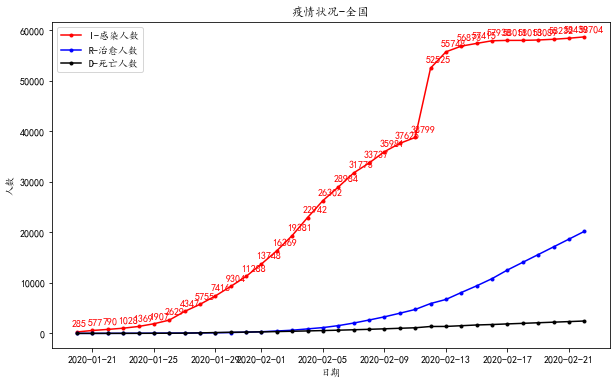

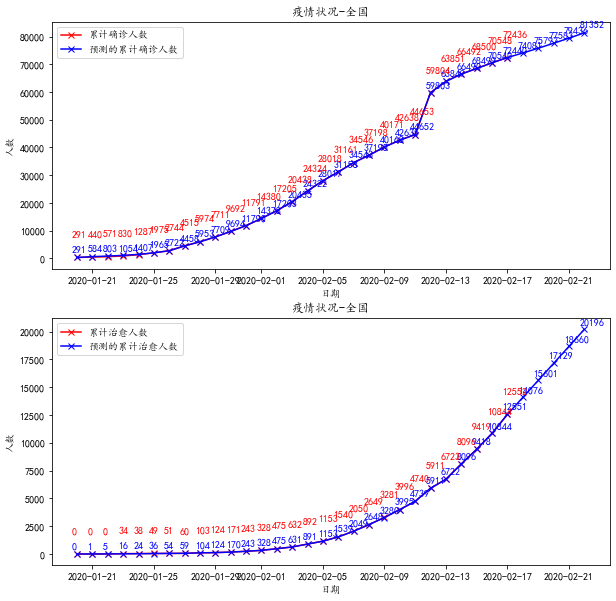

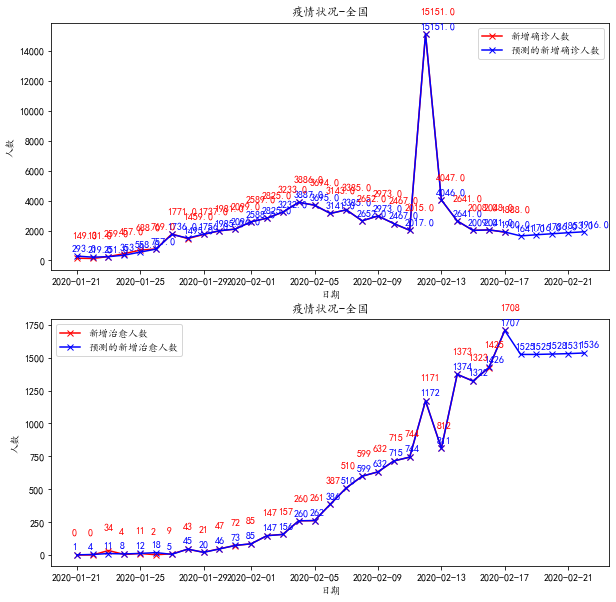

新增治愈： [   1    4   11    8   12   18    5   45   20   46   73   85  147  156
  260  262  386  510  599  632  715  744 1172  811 1374 1322 1426 1707
 1525 1525 1528 1531 1536]
新增确诊： [  293.   219.   251.   353.   558.   757.  1736.  1495.  1756.  1985.
  2096.  2588.  2825.  3232.  3887.  3695.  3141.  3385.  2652.  2973.
  2467.  2017. 15151.  4046.  2641.  2009.  2041.  1900.  1641.  1716.
  1786.  1853.  1916.]


In [170]:
model = load_model_predict(model_city_date_path, data, param_pred=True, city_name=city_name,pred_date_len=5)
# plot_param(model,city_name,data,xlen=15)
# model_city_date_path 1618

In [138]:
import datetime
'''
1.某个地方第一次训练设置load_param=False,之后默认为True  
2.默认使用参数预测，use_param_pred=false
3.param_date指定加载哪一天的模型参数,默认为''
4.多次训练的时候可指定训练轮数和学习率，默认为2000,0.001
'''
def train_predict(N_init,city_name,param_date='',load_param=True,use_param_pred=True,eprochs=2000,lr_rate=0.001):
    def get_today():
        today = datetime.datetime.today()
        today+=datetime.timedelta(days=-2)
        format_datetime = lambda x :f'0{x.month}{x.day}' if x.month<10 else f'{x.month}-{x.day}'
        return format_datetime(today)
    city_pinyins={'北京':'beijing', '上海':'shanghai', '重庆':'chongqing'}
    #获取今日日期的字符串  '02-13'格式
    model_save_time=get_today()
    city_pinyin=city_pinyins[city_name]
    data=read_data('./ncov/data/'+city_pinyin+'_截至'+model_save_time+'_24时.csv')  ##这里需要把allcity里面的update_time 改成time
    param_path=''
    #默认为空 直接加载最近的参数 如果指定日期，则会加载指定日期的参数
    if param_date!='':
        param_path='models/'+city_pinyin+'/'+param_date
    model_city_date_path = train_with_city_data(data,N_init,model_save_time,city_name,max_epoches=eprochs,is_train=True,load_param_save=load_param,lr_init=lr_rate,param_path=param_path)
    model = load_model_predict(model_city_date_path, data, param_pred=use_param_pred, city_name=city_name,pred_date_len=5)
    plot_param(model,city_name,data,xlen=15)

In [16]:
def format_output(model_city_date_path, data, param_pred=False, city_name='深圳',c='confirmed', features=['I','cured','dead'], pred_date_len=5, data_dict={'累计':{},'新增':{}},data_dict_report={'累计':{},'新增':{}}):
    I_name,recover_name,dead_name = features
    model_pt = os.path.join(model_city_date_path,'model.pt')
    model = torch.load(model_pt)
    I = model.I_tensor_cur
    R = model.R_tensor_cur
    D = model.D_tensor_cur
    I_pred_old = (I.detach().numpy()).astype(np.int)
    R_pred_old = (R.detach().numpy()).astype(np.int)
    D_pred_old = (D.detach().numpy()).astype(np.int)

    confirm_pred = cal_acc_confirm(I_pred_old,R_pred_old,D_pred_old)
    confirm_origin = get_data_acc_confirm(data,c=c)
    # print(confirm_origin)
    new_confirm = cal_new_confirm(np.array(data[I_name]),np.array(data[recover_name]),np.array(data[dead_name]))
    cal_acc_confirm(I_pred_old,R_pred_old,D_pred_old)
    new_confirm_pred = cal_new_confirm(I_pred_old,R_pred_old,D_pred_old)

    if param_pred:
        beta = []
        theta = []
        gamma_2 = []
        alpha = []
        for i in range(len(model.SEIR_cells)):
            beta.append(model.SEIR_cells[i].beta.detach().numpy()[0])
            gamma_2.append(model.SEIR_cells[i].gamma_2.detach().numpy()[0])
            theta.append(model.SEIR_cells[i].theta.detach().numpy()[0])
            alpha.append(model.SEIR_cells[i].alpha.detach().numpy()[0])

        param = model.param_pred(beta,gamma_2,theta,alpha)

#         print(param)
        S_pred_tensor, I_pred_tensor, E_pred_tensor, R_pred_tensor, D_pred_tensor = model.pred(param=param, pred_date_len = pred_date_len)
    else:
        S_pred_tensor, I_pred_tensor, E_pred_tensor, R_pred_tensor, D_pred_tensor = model.pred(pred_date_len = pred_date_len)

    I_pred_new = (I_pred_tensor.detach().numpy()).astype(np.int)
    R_pred_new = (R_pred_tensor.detach().numpy()).astype(np.int)
    D_pred_new = (D_pred_tensor.detach().numpy()).astype(np.int)
    I_pred_total = np.concatenate((I_pred_old,I_pred_new),axis=0)
    R_pred_total = np.concatenate((R_pred_old,R_pred_new),axis=0)
    D_pred_total = np.concatenate((D_pred_old,D_pred_new),axis=0)

    # plot_SEIRD(data, I=I_pred_total, R=R_pred_total, D=D_pred_total, city=city_name, pred_date_len=pred_date_len)

    confirm_pred = cal_acc_confirm(I_pred_total,R_pred_total,D_pred_total)
    confirm_origin = get_data_acc_confirm(data,c=c)
    # plot_daily_acc(data, confirm_origin, confirm_pred, city=city_name, pred_date_len=pred_date_len)

    new_confirm_pred_total = cal_new_confirm(I_pred_total,R_pred_total,D_pred_total)
    new_confirm_pred_total
    # plot_daily_new(data, new_confirm, new_confirm_pred_total, city=city_name, pred_date_len=pred_date_len)

    T_name = 'time'
    time_val = data[T_name].values

    max_time_val = data[T_name].values.max()
    pred_time = []
    for i in range(1, pred_date_len + 1):
        pred_time.append(max_time_val + np.timedelta64(i, 'D'))
    if pred_time == []:
        merge_time = time_val
    else:
        merge_time = np.concatenate((time_val, pred_time), axis=0)
    # pd.to_datetime()
    def format_datetime(x):
        xd = x.date()
        fxd = ''
        if xd.month<10 and xd.day<10:
            fxd = f'0{xd.month}-0{xd.day}'
        elif xd.month<10 and xd.day>=10: 
            fxd = f'0{xd.month}-{xd.day}'
        else:
            fxd = f'{xd.month}-{xd.day}'
        return fxd
    dates_list = [format_datetime(pd.to_datetime(d)) for d in merge_time]
    data_dict_report['累计'][city_name] = dict.fromkeys(dates_list)
    data_dict_report['新增'][city_name] = dict.fromkeys(dates_list)
    temp=[]
    for i,p in enumerate(confirm_pred):
        data_dict['累计'][city_name].append([dates_list[i],p])
        data_dict_report['累计'][city_name][dates_list[i]]=p
    for i,p in enumerate(new_confirm_pred_total):
        data_dict['新增'][city_name].append([dates_list[i+1],p])
        data_dict_report['新增'][city_name][dates_list[i+1]]=p
    return data_dict,data_dict_report

cured_ratio: 4.6625
dead_ratio: 186.5
{'beta': [1.1144036673161293, 1.0313712742559524, 0.9440478628729808, 0.7392976878675228, 0.6549396559330318, 0.6249162761748509, 0.5688449805350521, 0.549097888971826, 0.5423572551867236, 0.5298103579456542, 0.5337236052059547, 0.4527958824210194, 0.42337530364707454, 0.4342297419034859, 0.41621180027949667, 0.41148633369029364, 0.38080570962513455, 0.3332032762324669, 0.3425667127573697, 0.3346689006017409, 0.2649156173240452, 0.26452654033584444, 0.25130252544778575, 0.23613569550193084, 0.19995002673285134, 0.19674105909428388, 0.19667111449934102], 'theta': [-6.186870448159784e-06, 8.532919709545764e-06, -0.00019515736629323595, 0.0004303652831614029, -0.17398172568562645, -0.0005213921612508391, 8.327109241288152e-06, -1.9316829392759105e-05, 1.4573753690809278e-05, 9.424978868173384e-06, 7.72838064144831e-06, -7.14569381063755e-06, 6.8120241180138894e-06, 6.535928373884283e-06, -6.327529226134537e-06, 6.186062979900576e-06, 6.156385408427503

Training step:  129
Loss: 0.016838100223240348
Training step:  130
Loss: 0.01679172270134777
Training step:  131
Loss: 0.01676261813284692
Training step:  132
Loss: 0.01671520914371254
Training step:  133
Loss: 0.016680585642812863
Training step:  134
Loss: 0.016638939348286294
Training step:  135
Loss: 0.016599256089774885
Training step:  136
Loss: 0.0165558721477993
Training step:  137
Loss: 0.01652517339956195
Training step:  138
Loss: 0.016480750043164936
Training step:  139
Loss: 0.01644476012756277
Training step:  140
Loss: 0.016406011648605758
Training step:  141
Loss: 0.016365065865989813
Training step:  142
Loss: 0.01632451077012013
Training step:  143
Loss: 0.016292377132766427
Training step:  144
Loss: 0.016250729032294277
Training step:  145
Loss: 0.016213553401038475
Training step:  146
Loss: 0.016177450994814303
Training step:  147
Loss: 0.01614236081631499
Training step:  148
Loss: 0.016104726797963057
Training step:  149
Loss: 0.016065002436032354
Training step:  150
Lo

Training step:  307
Loss: 0.011543485994222126
Training step:  308
Loss: 0.011514188350541216
Training step:  309
Loss: 0.01150296380187029
Training step:  310
Loss: 0.011471961499573328
Training step:  311
Loss: 0.011459196425827352
Training step:  312
Loss: 0.011429881897814319
Training step:  313
Loss: 0.011415889587610034
Training step:  314
Loss: 0.011388250488335054
Training step:  315
Loss: 0.011376194879639685
Training step:  316
Loss: 0.011346873060272591
Training step:  317
Loss: 0.011333482159115138
Training step:  318
Loss: 0.011305815163646362
Training step:  319
Loss: 0.01129603446076413
Training step:  320
Loss: 0.011265054673849586
Training step:  321
Loss: 0.011253939459117148
Training step:  322
Loss: 0.011224594673090811
Training step:  323
Loss: 0.011217119043149712
Training step:  324
Loss: 0.011184504285164345
Training step:  325
Loss: 0.011175634169980048
Training step:  326
Loss: 0.011144638851915693
Training step:  327
Loss: 0.011137879191119797
Training step: 

Training step:  482
Loss: 0.008948153278063791
Training step:  483
Loss: 0.008946256919234077
Training step:  484
Loss: 0.008929088531697674
Training step:  485
Loss: 0.008926470922025425
Training step:  486
Loss: 0.008911606470035641
Training step:  487
Loss: 0.008910660239670397
Training step:  488
Loss: 0.008894329585371112
Training step:  489
Loss: 0.00889130471949421
Training step:  490
Loss: 0.00887595897753468
Training step:  491
Loss: 0.008875975437631306
Training step:  492
Loss: 0.008859175473479537
Training step:  493
Loss: 0.008857051329192362
Training step:  494
Loss: 0.008842529961681608
Training step:  495
Loss: 0.008838447723424864
Training step:  496
Loss: 0.00882487617772734
Training step:  497
Loss: 0.008823695552080735
Training step:  498
Loss: 0.008808674526168798
Training step:  499
Loss: 0.00880551806550757
Training step:  500
Loss: 0.008792746205535001
Training step:  501
Loss: 0.008791234486101451
Training step:  502
Loss: 0.008775713891281086
Training step:  5

Loss: 0.008135035286048363
Training step:  661
Loss: 0.008135904199992891
Training step:  662
Loss: 0.008133521370422305
Training step:  663
Loss: 0.008135076289304833
Training step:  664
Loss: 0.008133062172711059
Training step:  665
Loss: 0.008134255391294355
Training step:  666
Loss: 0.008131568388226821
Training step:  667
Loss: 0.008133448625807154
Training step:  668
Loss: 0.008131124652352963
Training step:  669
Loss: 0.008132645712867636
Training step:  670
Loss: 0.00813069212422011
Training step:  671
Loss: 0.008131856029393031
Training step:  672
Loss: 0.00812923199602109
Training step:  673
Loss: 0.008131074569577783
Training step:  674
Loss: 0.008128814401646894
Training step:  675
Loss: 0.008130302604262087
Training step:  676
Loss: 0.00812737348085829
Training step:  677
Loss: 0.008129541743062612
Training step:  678
Loss: 0.008126971777913819
Training step:  679
Loss: 0.008128787146350687
Training step:  680
Loss: 0.008125558872922654
Training step:  681
Loss: 0.00812804

Training step:  837
Loss: 0.008094238479127998
Training step:  838
Loss: 0.008093270610656917
Training step:  839
Loss: 0.008094154635376556
Training step:  840
Loss: 0.008093188055696664
Training step:  841
Loss: 0.008094071026325637
Training step:  842
Loss: 0.008093105730832426
Training step:  843
Loss: 0.008093987649156585
Training step:  844
Loss: 0.008093023507566294
Training step:  845
Loss: 0.008093904498779492
Training step:  846
Loss: 0.008092936309644005
Training step:  847
Loss: 0.008093821549394656
Training step:  848
Loss: 0.008092043809403324
Training step:  849
Loss: 0.008093477789534061
Training step:  850
Loss: 0.00809196167877901
Training step:  851
Loss: 0.0080933950254328
Training step:  852
Loss: 0.00809188150411956
Training step:  853
Loss: 0.008093312500852422
Training step:  854
Loss: 0.008091801058109825
Training step:  855
Loss: 0.008093230207711551
Training step:  856
Loss: 0.008091720947218481
Training step:  857
Loss: 0.008093148147530775
Training step:  8

Loss: 0.008082109176333018
Training step:  1014
Loss: 0.008076112194599961
Training step:  1015
Loss: 0.008082040764390869
Training step:  1016
Loss: 0.008076052937970498
Training step:  1017
Loss: 0.008081972550401361
Training step:  1018
Loss: 0.008075993532077991
Training step:  1019
Loss: 0.008081904526459594
Training step:  1020
Loss: 0.008075934594367012
Training step:  1021
Loss: 0.008081836698364991
Training step:  1022
Loss: 0.008075875626595385
Training step:  1023
Loss: 0.00808176905574273
Training step:  1024
Loss: 0.008075817032878482
Training step:  1025
Loss: 0.008081701610702157
Training step:  1026
Loss: 0.008075758210033469
Training step:  1027
Loss: 0.008081634345152758
Training step:  1028
Loss: 0.008075700103337958
Training step:  1029
Loss: 0.008081567278883572
Training step:  1030
Loss: 0.008075641711309868
Training step:  1031
Loss: 0.008081500400141474
Training step:  1032
Loss: 0.008075583578880198
Training step:  1033
Loss: 0.008081433706437985
Training step:

Training step:  1187
Loss: 0.008071031373531901
Training step:  1188
Loss: 0.008063670225911281
Training step:  1189
Loss: 0.008070976495872103
Training step:  1190
Loss: 0.008063626124114407
Training step:  1191
Loss: 0.00807092176032832
Training step:  1192
Loss: 0.008063582457194442
Training step:  1193
Loss: 0.008070867172850776
Training step:  1194
Loss: 0.008063539009524768
Training step:  1195
Loss: 0.008070812729700352
Training step:  1196
Loss: 0.008063495412852046
Training step:  1197
Loss: 0.008070758424195005
Training step:  1198
Loss: 0.008063452017567108
Training step:  1199
Loss: 0.008070704251379481
Training step:  1200
Loss: 0.0080634086052882
Training step:  1201
Loss: 0.008070650200514123
Training step:  1202
Loss: 0.008063365674953409
Training step:  1203
Loss: 0.008070596259917217
Training step:  1204
Loss: 0.008063322509391128
Training step:  1205
Loss: 0.00807054239595201
Training step:  1206
Loss: 0.008063279390097886
Training step:  1207
Loss: 0.008070488525878

Loss: 0.008062380873250119
Training step:  1362
Loss: 0.008052410835814532
Training step:  1363
Loss: 0.008062335295529514
Training step:  1364
Loss: 0.008052380104406665
Training step:  1365
Loss: 0.008062289833566359
Training step:  1366
Loss: 0.0080523493110517
Training step:  1367
Loss: 0.00806224448296678
Training step:  1368
Loss: 0.008052318943102828
Training step:  1369
Loss: 0.008062199243875245
Training step:  1370
Loss: 0.008052288342299648
Training step:  1371
Loss: 0.008062154107668683
Training step:  1372
Loss: 0.008052257831811384
Training step:  1373
Loss: 0.00806210906427489
Training step:  1374
Loss: 0.008052227548453065
Training step:  1375
Loss: 0.008062064098667436
Training step:  1376
Loss: 0.008052197243233335
Training step:  1377
Loss: 0.008062019187271447
Training step:  1378
Loss: 0.008052167111537846
Training step:  1379
Loss: 0.008061974244633485
Training step:  1380
Loss: 0.008052135373598633
Training step:  1381
Loss: 0.00806192870365043
Training step:  13

Training step:  1533
Loss: 0.008056213050833979
Training step:  1534
Loss: 0.008046003320945587
Training step:  1535
Loss: 0.008056175926935515
Training step:  1536
Loss: 0.008045981342512717
Training step:  1537
Loss: 0.008056138900291152
Training step:  1538
Loss: 0.008045959342062018
Training step:  1539
Loss: 0.008056101966332354
Training step:  1540
Loss: 0.008045937629921486
Training step:  1541
Loss: 0.008056065132803695
Training step:  1542
Loss: 0.008045915805894142
Training step:  1543
Loss: 0.008056028394034803
Training step:  1544
Loss: 0.008045894231493282
Training step:  1545
Loss: 0.00805599175192588
Training step:  1546
Loss: 0.008045872551514165
Training step:  1547
Loss: 0.00805595520461073
Training step:  1548
Loss: 0.00804585085519912
Training step:  1549
Loss: 0.00805591874254456
Training step:  1550
Loss: 0.00804582956193513
Training step:  1551
Loss: 0.008055882382978274
Training step:  1552
Loss: 0.008045807997490653
Training step:  1553
Loss: 0.0080558461157147

Loss: 0.008039348533050073
Training step:  1705
Loss: 0.008050638402334852
Training step:  1706
Loss: 0.008039333979909576
Training step:  1707
Loss: 0.008050005395877646
Training step:  1708
Loss: 0.008039355545882353
Training step:  1709
Loss: 0.008049902708443768
Training step:  1710
Loss: 0.008039340710589805
Training step:  1711
Loss: 0.008049872105274088
Training step:  1712
Loss: 0.008039325798552802
Training step:  1713
Loss: 0.008049841580007593
Training step:  1714
Loss: 0.00803931085199398
Training step:  1715
Loss: 0.008049811133004738
Training step:  1716
Loss: 0.008039295828386866
Training step:  1717
Loss: 0.008049780760456546
Training step:  1718
Loss: 0.008039280576401167
Training step:  1719
Loss: 0.008049750466412946
Training step:  1720
Loss: 0.00803903940000823
Training step:  1721
Loss: 0.008049651667531495
Training step:  1722
Loss: 0.008039025057618223
Training step:  1723
Loss: 0.008049621416089975
Training step:  1724
Loss: 0.008039010524858205
Training step: 

Training step:  1878
Loss: 0.008031885589663513
Training step:  1879
Loss: 0.008042538698013833
Training step:  1880
Loss: 0.00803187420273855
Training step:  1881
Loss: 0.008042512736866746
Training step:  1882
Loss: 0.008031862943036799
Training step:  1883
Loss: 0.008042486778693719
Training step:  1884
Loss: 0.008031851744404107
Training step:  1885
Loss: 0.00804246075024588
Training step:  1886
Loss: 0.008031840689345364
Training step:  1887
Loss: 0.008042434152613489
Training step:  1888
Loss: 0.008031829756686508
Training step:  1889
Loss: 0.00804194927194594
Training step:  1890
Loss: 0.008031846400750667
Training step:  1891
Loss: 0.008041710759195393
Training step:  1892
Loss: 0.008031657273329058
Training step:  1893
Loss: 0.008041531582645494
Training step:  1894
Loss: 0.008031469670988802
Training step:  1895
Loss: 0.008041505887027954
Training step:  1896
Loss: 0.008031458732178632
Training step:  1897
Loss: 0.008041481001147365
Training step:  1898
Loss: 0.00803144793081

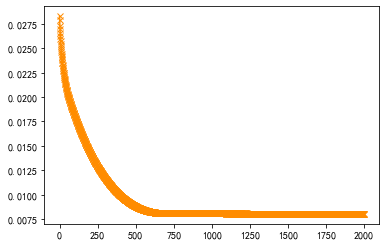

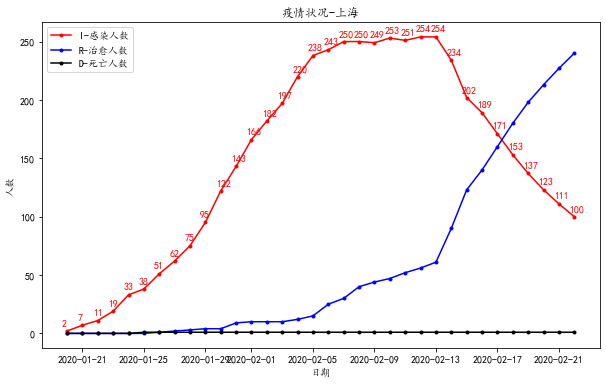

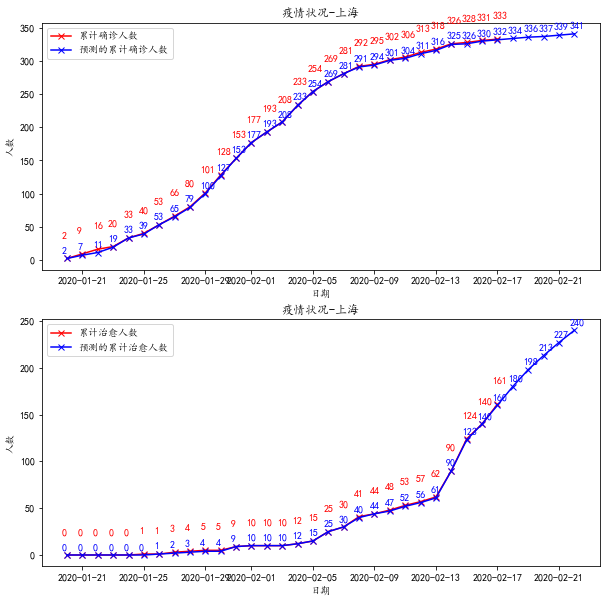

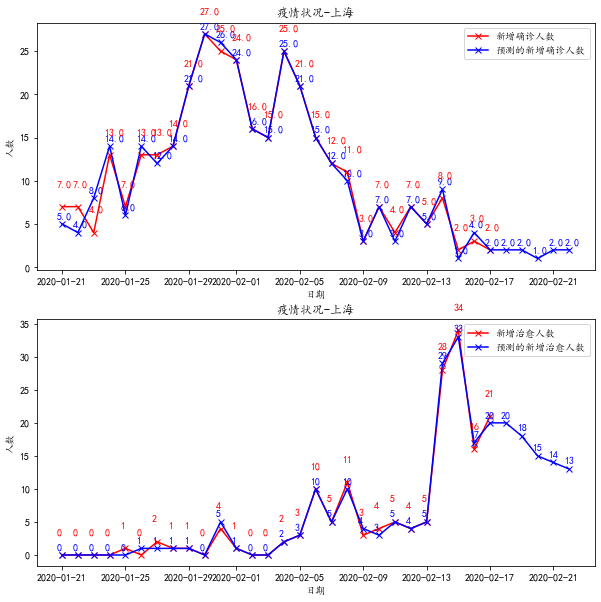

新增治愈： [ 0  0  0  0  0  1  1  1  1  0  5  1  0  0  2  3 10  5 10  4  3  5  4  5
 29 33 17 20 20 18 15 14 13]
新增确诊： [ 5.  4.  8. 14.  6. 14. 12. 14. 21. 27. 26. 24. 16. 15. 25. 21. 15. 12.
 10.  3.  7.  3.  7.  5.  9.  1.  4.  2.  2.  2.  1.  2.  2.]
beta: [1.114430758150335, 1.0313983622922342, 0.944074949756139, 0.739324775163049, 0.654966744010082, 0.6249433641971783, 0.568872068863025, 0.5491249775768935, 0.5423843440630451, 0.5298374472942922, 0.5337506951094759, 0.4528229726914416, 0.42340239462065293, 0.43425683351320504, 0.4160988934163606, 0.4113734293185983, 0.3806928103593951, 0.3329505974448424, 0.3418959332829324, 0.33372018553694577, 0.2620461857993404, 0.26084600351362325, 0.24575730200916804, 0.22647123391280002, 0.16807786924801713, 0.16044313572853244, 0.15189747388521274, 0.1818759091922378]
gamma_2: [-6.154907585661412e-05, 8.532062659925808e-05, 0.00024475620154740404, 0.019324277881804103, -0.1646117134587971, 0.0698599235599179, 0.19312958560784976, 0.1270607615465

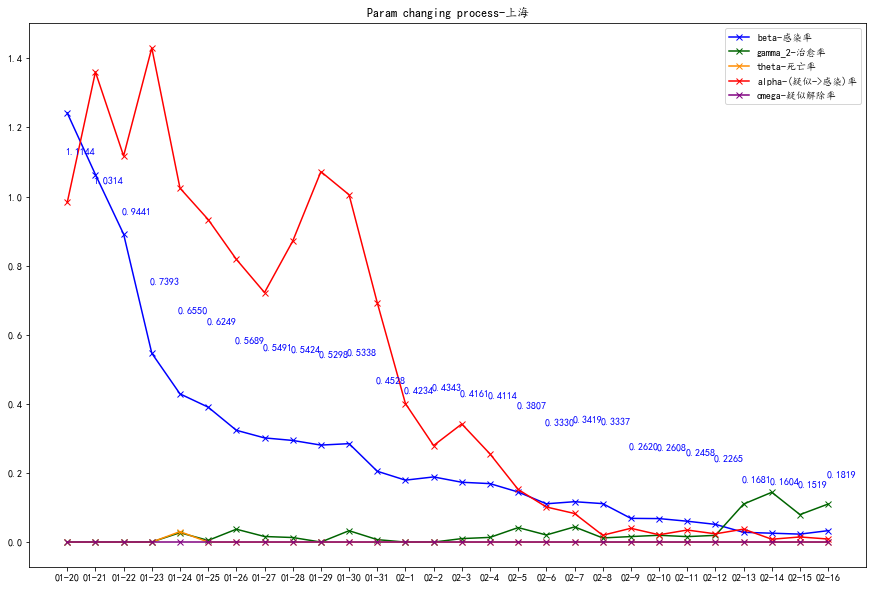

In [149]:
other_citys=['北京','上海']
populatinos=[21540000.,24240000.,30480000.]
param_date='0216'  #指定日期则加载指定日期的参数
# for i in range(len(other_citys)):
i=1
city_name=other_citys[i]
N=populatinos[i]
#第一次训练
# train_predict(N,city_name,param_date=param_date,load_param=False,lr_rate=0.01)
train_predict(N,city_name,param_date=param_date,load_param=True,eprochs=2000,lr_rate=0.00007)

In [140]:
time='0217'
citys=['北京','上海']
paths=['./ncov/data/beijing_截至'+time+'_24时.csv','./ncov/data/shanghai_截至'+time+'_24时.csv']
modelpath=['./models/beijing/'+time,'./models/shanghai/'+time]

def init_data_dict(citys):
    data_dict = dict.fromkeys(['累计','新增'])
    for k in data_dict.keys():
        data_dict[k] = dict.fromkeys(citys)
        for dc in data_dict[k].keys():
            data_dict[k][dc]=[]
    return data_dict

data_dict = init_data_dict(citys)
data_dict_report = init_data_dict(citys)
for i in range(len(citys)):
    city_name=citys[i]
    print(city_name)
    data=read_data(paths[i])
    data_dict,data_dict_report = format_output(modelpath[i], data, param_pred=True, city_name=city_name,features=['I','cured','dead'], pred_date_len=5, data_dict=data_dict,data_dict_report=data_dict_report)
print(data_dict)

北京


FileNotFoundError: [Errno 2] No such file or directory: './models/beijing/0217\\model.pt'

In [ ]:
for i in range(len(citys)):
    city_name=citys[i]
    if city_name=='全国':
        continue
    data=read_data(paths[i])
    if city_name=='深圳':
        data_dict = format_output(modelpath[i], data, param_pred=False, city_name=city_name,features=['I','cured','dead'], pred_date_len=5, data_dict=data_dict)
    else:
        data_dict = format_output(modelpath[i], data, param_pred=True, city_name=city_name,features=['I','cured','dead'], pred_date_len=5, data_dict=data_dict)